# Randomized Search with Hyperopt

In this notebook, we will perform Randomized Search to select the best hyperparameters for a Gradient Boosting Classifier, using the open source Python package Hyperopt.

The randomized search is performed with the class rand.

I find the documentation for Hyperopt quite unintuitive, so it helps to refer to the original article to understand the different parameters and classes.

To step out of Scikit-learn, we will optimise the parameters of a Gradient Boosting Machine of the xgboost package.
Procedure

To tune the hyper-parameters of our model we need to:

    define a model
    define the hyperparameter space
    define the objective function we want to minimize

In [1]:
%pylab inline
%load_ext autoreload
%autoreload 2

Populating the interactive namespace from numpy and matplotlib


In [2]:
import sys
sys.path.insert(0,'../..')
import omama as O
import numpy as np
import pandas as pd
import sklearn
import matplotlib.pyplot as plt

from sklearn.metrics import accuracy_score
from sklearn.model_selection import cross_val_score, train_test_split

from scipy.spatial.distance import braycurtis, canberra, chebyshev, correlation, dice, hamming, jaccard, kulsinski, mahalanobis, matching, minkowski, rogerstanimoto, russellrao, seuclidean, sokalmichener, sokalsneath, sqeuclidean, yule
import scipy

import xgboost as xgb
import mahotas as mh
from hyperopt import hp, rand, fmin, Trials
from pyod.models.knn import KNN
import pickle

In [3]:
with open('/raid/mpsych/datasetA.pkl','rb') as f:
    datasetA_X = pickle.load(f)
    
with open('/raid/mpsych/datasetA_labels.pkl', 'rb') as f1:
    datasetA_y = np.asarray(pickle.load(f1))

In [4]:
datasetA_X

[namespace(filePath='/raid/data01/deephealth/dh_dcm_ast/2.25.100092564201717920227778015190137094051/DXm.2.25.177313671738924764407441602033767426589',
           SOPInstanceUID='2.25.177313671738924764407441602033767426589',
           StudyInstanceUID='2.25.100092564201717920227778015190137094051',
           label='NonCancer',
           imageLaterality='R',
           shape=(2294, 1914),
           metadata=None,
           pixels=array([[   0,    0,    0, ..., 2429, 2430, 2443],
                         [   0,    0,    0, ..., 2420, 2446, 2457],
                         [   0,    0,    0, ..., 2444, 2461, 2454],
                         ...,
                         [   0,    0,    0, ..., 2481, 2505, 2536],
                         [   0,    0,    0, ..., 2494, 2521, 2527],
                         [   0,    0,    0, ..., 2510, 2525, 2541]], dtype=uint16)),
 namespace(filePath='/raid/data01/deephealth/dh_dcm_ast/2.25.100056448714550243466666217784204906604/DXm.2.25.11082538545613

In [5]:
X_feat_vect = O.Features.get_features(datasetA_X, feature_type='hist', norm_type='gaussian')

In [7]:
pixels = []
for img in datasetA_X:
    pixels.append(img.pixels)

In [17]:
normalized_pixels = []
for p in pixels:
    temp_pixels = mh.gaussian_filter(p, sigma=1)
    temp_pixels /= temp_pixels.max()
#     temp_pixels *= 255
    normalized_pixels.append(temp_pixels)
    

In [14]:
normalized_pixels

[array([[  0.        ,   0.        ,   0.        , ..., 166.42565412,
         166.87479385, 167.29836037],
        [  0.        ,   0.        ,   0.        , ..., 166.66078203,
         167.21582858, 167.65613834],
        [  0.        ,   0.        ,   0.        , ..., 166.86972808,
         167.42394733, 167.88653966],
        ...,
        [  0.        ,   0.        ,   0.        , ..., 170.83899212,
         171.93994697, 172.81023732],
        [  0.        ,   0.        ,   0.        , ..., 171.20653155,
         172.23072063, 172.99609712],
        [  0.        ,   0.        ,   0.        , ..., 171.60193937,
         172.57246781, 173.25827474]]),
 array([[  7.77100132,   7.65444682,   7.56317724, ..., 210.62366824,
         208.25479145, 206.7924234 ],
        [  7.77788898,   7.65973427,   7.56603361, ..., 210.04534158,
         208.10804537, 206.85326155],
        [  7.74354902,   7.62461547,   7.51882002, ..., 209.04200583,
         207.86678488, 206.94836817],
        ...,


In [18]:
histograms =[]
for norms in normalized_pixels:
    histograms.append(mh.fullhistogram(norms.astype(np.uint8)))

In [19]:
histograms

[array([4390715,       1], dtype=uint32),
 array([7330427,       1], dtype=uint32),
 array([4390715,       1], dtype=uint32),
 array([4390715,       1], dtype=uint32),
 array([7330427,       1], dtype=uint32),
 array([4390715,       1], dtype=uint32),
 array([4390715,       1], dtype=uint32),
 array([7330312,     116], dtype=uint32),
 array([4390715,       1], dtype=uint32),
 array([4390715,       1], dtype=uint32),
 array([7330427,       1], dtype=uint32),
 array([13631022,      466], dtype=uint32),
 array([7330427,       1], dtype=uint32),
 array([7330427,       1], dtype=uint32),
 array([7330427,       1], dtype=uint32),
 array([7330427,       1], dtype=uint32),
 array([4390715,       1], dtype=uint32),
 array([7330427,       1], dtype=uint32),
 array([7330427,       1], dtype=uint32),
 array([4390715,       1], dtype=uint32),
 array([7329452,     976], dtype=uint32),
 array([7330427,       1], dtype=uint32),
 array([7330427,       1], dtype=uint32),
 array([7330427,       1], dtype

In [6]:
X_feat_vect

[array([4390715,       1], dtype=uint32),
 array([7330427,       1], dtype=uint32),
 array([4390715,       1], dtype=uint32),
 array([4390715,       1], dtype=uint32),
 array([7330427,       1], dtype=uint32),
 array([4390715,       1], dtype=uint32),
 array([4390715,       1], dtype=uint32),
 array([7330312,     116], dtype=uint32),
 array([4390715,       1], dtype=uint32),
 array([4390715,       1], dtype=uint32),
 array([7330427,       1], dtype=uint32),
 array([13631022,      466], dtype=uint32),
 array([7330427,       1], dtype=uint32),
 array([7330427,       1], dtype=uint32),
 array([7330427,       1], dtype=uint32),
 array([7330427,       1], dtype=uint32),
 array([4390715,       1], dtype=uint32),
 array([7330427,       1], dtype=uint32),
 array([7330427,       1], dtype=uint32),
 array([4390715,       1], dtype=uint32),
 array([7329452,     976], dtype=uint32),
 array([7330427,       1], dtype=uint32),
 array([7330427,       1], dtype=uint32),
 array([7330427,       1], dtype

In [12]:
X = pd.DataFrame(X_feat_vect)

In [13]:
y = pd.Series(datasetA_y)

In [14]:
# the target:
# percentage of unwanted images (0) to wanted images (1)

y.value_counts() / len(y)

0    0.92
1    0.08
dtype: float64

In [15]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=0
)
X_train.shape, X_test.shape

((80, 2), (20, 2))

In [17]:
X_train

,0,1
43,4390715,1
62,4390715,1
3,4390715,1
71,4390715,1
45,13631022,466
...,...,...
96,13631487,1
67,8519223,457
64,7330427,1
47,4390715,1


## Define the Hyperparameter Space

- [Hyperopt search space](http://hyperopt.github.io/hyperopt/getting-started/search_spaces/)

- [xgb.XGBClassifier hyperparameters](https://xgboost.readthedocs.io/en/latest/python/python_api.html#xgboost.XGBClassifier)

- [xgb general parameters](https://xgboost.readthedocs.io/en/latest/parameter.html)

In [9]:
# determine the hyperparameter space

param_grid = {
    'contamination': hp.uniform('contamination', 0.07, .1),
    'n_neighbors': hp.uniformint('n_neighbors', 1, 50),
    'method': hp.choice('method', ['largest', 'mean', 'median']),
    'radius': hp.quniform('radius', 0.0, 5.0, .1),
    'leaf_size': hp.uniformint('leaf_size', 1, 100),
    'metric': hp.choice('metric', ['minkowski', 'cityblock', 'euclidean', 'l1', 'l2', 'manhattan', 
                                  ]),
    'p': hp.uniformint('p', 1, 10),
    'n_jobs': hp.uniformint('n_jobs', 1, 4)
}

In [10]:
sklearn.metrics.SCORERS.keys()

dict_keys(['explained_variance', 'r2', 'max_error', 'neg_median_absolute_error', 'neg_mean_absolute_error', 'neg_mean_absolute_percentage_error', 'neg_mean_squared_error', 'neg_mean_squared_log_error', 'neg_root_mean_squared_error', 'neg_mean_poisson_deviance', 'neg_mean_gamma_deviance', 'accuracy', 'top_k_accuracy', 'roc_auc', 'roc_auc_ovr', 'roc_auc_ovo', 'roc_auc_ovr_weighted', 'roc_auc_ovo_weighted', 'balanced_accuracy', 'average_precision', 'neg_log_loss', 'neg_brier_score', 'adjusted_rand_score', 'rand_score', 'homogeneity_score', 'completeness_score', 'v_measure_score', 'mutual_info_score', 'adjusted_mutual_info_score', 'normalized_mutual_info_score', 'fowlkes_mallows_score', 'precision', 'precision_macro', 'precision_micro', 'precision_samples', 'precision_weighted', 'recall', 'recall_macro', 'recall_micro', 'recall_samples', 'recall_weighted', 'f1', 'f1_macro', 'f1_micro', 'f1_samples', 'f1_weighted', 'jaccard', 'jaccard_macro', 'jaccard_micro', 'jaccard_samples', 'jaccard_wei

## Define the objective function

This is the hyperparameter response space, the function we want to minimize.

In [11]:
# the objective function takes the hyperparameter space
# as input

def objective(params):

    # we need a dictionary to indicate which value from the space
    # to attribute to each value of the hyperparameter in the xgb
    params_dict = {
        'contamination': params['contamination'],
        'n_neighbors': int(params['n_neighbors']),
        'method':params['method'],
        'radius': params['radius'],
        'leaf_size': int(params['leaf_size']),
        'metric': params['metric'],
        'p': int(params['p']),
        'n_jobs': int(params['n_jobs'])
    }

    # with ** we pass the items in the dictionary as parameters
    # to the KNN algorithm
    clf = KNN(**params_dict)
    clf.fit(X_train)
    
    y_train_scores = clf.decision_scores_
    y_test_scores = clf.decision_function(X_test)

    # train with cv
    score = cross_val_score(clf, X_train, y_train,
                            scoring='roc_auc', cv=5, n_jobs=4).mean()

    # to minimize, we negate the score
    return -score

## Randomized Search

[fmin](http://hyperopt.github.io/hyperopt/getting-started/minimizing_functions/)

In [12]:
search = fmin(
    fn=objective,
    space=param_grid,
    max_evals=50,
    rstate=np.random.default_rng(42),
    algo=rand.suggest,
)

  0%|                                                                                                                                                                  | 0/50 [00:00<?, ?trial/s, best loss=?]

/home/ryan.zurrin001/miniconda3/envs/O/lib/python3.9/site-packages/pyod/models/base.py:412: UserWarning: y should not be presented in unsupervised learning.
  warnings.warn(
/home/ryan.zurrin001/miniconda3/envs/O/lib/python3.9/site-packages/pyod/models/base.py:412: UserWarning: y should not be presented in unsupervised learning.
  warnings.warn(
/home/ryan.zurrin001/miniconda3/envs/O/lib/python3.9/site-packages/pyod/models/base.py:412: UserWarning: y should not be presented in unsupervised learning.
  warnings.warn(
/home/ryan.zurrin001/miniconda3/envs/O/lib/python3.9/site-packages/pyod/models/base.py:412: UserWarning: y should not be presented in unsupervised learning.
  warnings.warn(


  2%|██▋                                                                                                                                   | 1/50 [00:05<04:42,  5.76s/trial, best loss: -0.19556706839876942]

/home/ryan.zurrin001/miniconda3/envs/O/lib/python3.9/site-packages/pyod/models/base.py:412: UserWarning: y should not be presented in unsupervised learning.
  warnings.warn(
/home/ryan.zurrin001/miniconda3/envs/O/lib/python3.9/site-packages/pyod/models/base.py:412: UserWarning: y should not be presented in unsupervised learning.
  warnings.warn(
/home/ryan.zurrin001/miniconda3/envs/O/lib/python3.9/site-packages/pyod/models/base.py:412: UserWarning: y should not be presented in unsupervised learning.
  warnings.warn(
/home/ryan.zurrin001/miniconda3/envs/O/lib/python3.9/site-packages/pyod/models/base.py:412: UserWarning: y should not be presented in unsupervised learning.
  warnings.warn(
/home/ryan.zurrin001/miniconda3/envs/O/lib/python3.9/site-packages/pyod/models/base.py:412: UserWarning: y should not be presented in unsupervised learning.
  warnings.warn(
/home/ryan.zurrin001/miniconda3/envs/O/lib/python3.9/site-packages/pyod/models/base.py:412: UserWarning: y should not be presented

  4%|█████▎                                                                                                                                | 2/50 [00:06<02:22,  2.96s/trial, best loss: -0.25459085972190476]

/home/ryan.zurrin001/miniconda3/envs/O/lib/python3.9/site-packages/pyod/models/base.py:412: UserWarning: y should not be presented in unsupervised learning.
  warnings.warn(
/home/ryan.zurrin001/miniconda3/envs/O/lib/python3.9/site-packages/pyod/models/base.py:412: UserWarning: y should not be presented in unsupervised learning.
  warnings.warn(
/home/ryan.zurrin001/miniconda3/envs/O/lib/python3.9/site-packages/pyod/models/base.py:412: UserWarning: y should not be presented in unsupervised learning.
  warnings.warn(
/home/ryan.zurrin001/miniconda3/envs/O/lib/python3.9/site-packages/pyod/models/base.py:412: UserWarning: y should not be presented in unsupervised learning.
  warnings.warn(
/home/ryan.zurrin001/miniconda3/envs/O/lib/python3.9/site-packages/pyod/models/base.py:412: UserWarning: y should not be presented in unsupervised learning.
  warnings.warn(


  6%|████████                                                                                                                              | 3/50 [00:07<01:38,  2.10s/trial, best loss: -0.25459085972190476]

/home/ryan.zurrin001/miniconda3/envs/O/lib/python3.9/site-packages/pyod/models/base.py:412: UserWarning: y should not be presented in unsupervised learning.
  warnings.warn(
/home/ryan.zurrin001/miniconda3/envs/O/lib/python3.9/site-packages/pyod/models/base.py:412: UserWarning: y should not be presented in unsupervised learning.
  warnings.warn(
/home/ryan.zurrin001/miniconda3/envs/O/lib/python3.9/site-packages/pyod/models/base.py:412: UserWarning: y should not be presented in unsupervised learning.
  warnings.warn(
/home/ryan.zurrin001/miniconda3/envs/O/lib/python3.9/site-packages/pyod/models/base.py:412: UserWarning: y should not be presented in unsupervised learning.
  warnings.warn(


  8%|██████████▋                                                                                                                           | 4/50 [00:08<01:06,  1.45s/trial, best loss: -0.25459085972190476]

/home/ryan.zurrin001/miniconda3/envs/O/lib/python3.9/site-packages/pyod/models/base.py:412: UserWarning: y should not be presented in unsupervised learning.
  warnings.warn(
/home/ryan.zurrin001/miniconda3/envs/O/lib/python3.9/site-packages/pyod/models/base.py:412: UserWarning: y should not be presented in unsupervised learning.
  warnings.warn(
/home/ryan.zurrin001/miniconda3/envs/O/lib/python3.9/site-packages/pyod/models/base.py:412: UserWarning: y should not be presented in unsupervised learning.
  warnings.warn(
/home/ryan.zurrin001/miniconda3/envs/O/lib/python3.9/site-packages/pyod/models/base.py:412: UserWarning: y should not be presented in unsupervised learning.
  warnings.warn(
/home/ryan.zurrin001/miniconda3/envs/O/lib/python3.9/site-packages/pyod/models/base.py:412: UserWarning: y should not be presented in unsupervised learning.
  warnings.warn(


 10%|█████████████▍                                                                                                                        | 5/50 [00:08<00:49,  1.10s/trial, best loss: -0.25459085972190476]

/home/ryan.zurrin001/miniconda3/envs/O/lib/python3.9/site-packages/pyod/models/base.py:412: UserWarning: y should not be presented in unsupervised learning.
  warnings.warn(
/home/ryan.zurrin001/miniconda3/envs/O/lib/python3.9/site-packages/pyod/models/base.py:412: UserWarning: y should not be presented in unsupervised learning.
  warnings.warn(
/home/ryan.zurrin001/miniconda3/envs/O/lib/python3.9/site-packages/pyod/models/base.py:412: UserWarning: y should not be presented in unsupervised learning.
  warnings.warn(
/home/ryan.zurrin001/miniconda3/envs/O/lib/python3.9/site-packages/pyod/models/base.py:412: UserWarning: y should not be presented in unsupervised learning.
  warnings.warn(
/home/ryan.zurrin001/miniconda3/envs/O/lib/python3.9/site-packages/pyod/models/base.py:412: UserWarning: y should not be presented in unsupervised learning.
  warnings.warn(


 12%|████████████████                                                                                                                      | 6/50 [00:09<00:39,  1.12trial/s, best loss: -0.25459085972190476]

/home/ryan.zurrin001/miniconda3/envs/O/lib/python3.9/site-packages/pyod/models/base.py:412: UserWarning: y should not be presented in unsupervised learning.
  warnings.warn(
/home/ryan.zurrin001/miniconda3/envs/O/lib/python3.9/site-packages/pyod/models/base.py:412: UserWarning: y should not be presented in unsupervised learning.
  warnings.warn(
/home/ryan.zurrin001/miniconda3/envs/O/lib/python3.9/site-packages/pyod/models/base.py:412: UserWarning: y should not be presented in unsupervised learning.
  warnings.warn(
/home/ryan.zurrin001/miniconda3/envs/O/lib/python3.9/site-packages/pyod/models/base.py:412: UserWarning: y should not be presented in unsupervised learning.
  warnings.warn(
/home/ryan.zurrin001/miniconda3/envs/O/lib/python3.9/site-packages/pyod/models/base.py:412: UserWarning: y should not be presented in unsupervised learning.
  warnings.warn(
/home/ryan.zurrin001/miniconda3/envs/O/lib/python3.9/site-packages/pyod/models/base.py:412: UserWarning: y should not be presented

 14%|██████████████████▉                                                                                                                    | 7/50 [00:10<00:39,  1.10trial/s, best loss: -0.3016656799646501]

/home/ryan.zurrin001/miniconda3/envs/O/lib/python3.9/site-packages/pyod/models/base.py:412: UserWarning: y should not be presented in unsupervised learning.
  warnings.warn(
/home/ryan.zurrin001/miniconda3/envs/O/lib/python3.9/site-packages/pyod/models/base.py:412: UserWarning: y should not be presented in unsupervised learning.
  warnings.warn(
/home/ryan.zurrin001/miniconda3/envs/O/lib/python3.9/site-packages/pyod/models/base.py:412: UserWarning: y should not be presented in unsupervised learning.
  warnings.warn(
/home/ryan.zurrin001/miniconda3/envs/O/lib/python3.9/site-packages/pyod/models/base.py:412: UserWarning: y should not be presented in unsupervised learning.
  warnings.warn(
/home/ryan.zurrin001/miniconda3/envs/O/lib/python3.9/site-packages/pyod/models/base.py:412: UserWarning: y should not be presented in unsupervised learning.
  warnings.warn(


 16%|█████████████████████▌                                                                                                                 | 8/50 [00:11<00:39,  1.07trial/s, best loss: -0.3016656799646501]

/home/ryan.zurrin001/miniconda3/envs/O/lib/python3.9/site-packages/pyod/models/base.py:412: UserWarning: y should not be presented in unsupervised learning.
  warnings.warn(
/home/ryan.zurrin001/miniconda3/envs/O/lib/python3.9/site-packages/pyod/models/base.py:412: UserWarning: y should not be presented in unsupervised learning.
  warnings.warn(
/home/ryan.zurrin001/miniconda3/envs/O/lib/python3.9/site-packages/pyod/models/base.py:412: UserWarning: y should not be presented in unsupervised learning.
  warnings.warn(
/home/ryan.zurrin001/miniconda3/envs/O/lib/python3.9/site-packages/pyod/models/base.py:412: UserWarning: y should not be presented in unsupervised learning.
  warnings.warn(
/home/ryan.zurrin001/miniconda3/envs/O/lib/python3.9/site-packages/pyod/models/base.py:412: UserWarning: y should not be presented in unsupervised learning.
  warnings.warn(


 18%|████████████████████████▍                                                                                                               | 9/50 [00:12<00:38,  1.07trial/s, best loss: -0.316136863456058]

/home/ryan.zurrin001/miniconda3/envs/O/lib/python3.9/site-packages/pyod/models/base.py:412: UserWarning: y should not be presented in unsupervised learning.
  warnings.warn(
/home/ryan.zurrin001/miniconda3/envs/O/lib/python3.9/site-packages/pyod/models/base.py:412: UserWarning: y should not be presented in unsupervised learning.
  warnings.warn(
/home/ryan.zurrin001/miniconda3/envs/O/lib/python3.9/site-packages/pyod/models/base.py:412: UserWarning: y should not be presented in unsupervised learning.
  warnings.warn(
/home/ryan.zurrin001/miniconda3/envs/O/lib/python3.9/site-packages/pyod/models/base.py:412: UserWarning: y should not be presented in unsupervised learning.
  warnings.warn(


 20%|███████████████████████████                                                                                                            | 10/50 [00:12<00:32,  1.23trial/s, best loss: -0.316136863456058]

/home/ryan.zurrin001/miniconda3/envs/O/lib/python3.9/site-packages/pyod/models/base.py:412: UserWarning: y should not be presented in unsupervised learning.
  warnings.warn(
/home/ryan.zurrin001/miniconda3/envs/O/lib/python3.9/site-packages/pyod/models/base.py:412: UserWarning: y should not be presented in unsupervised learning.
  warnings.warn(
/home/ryan.zurrin001/miniconda3/envs/O/lib/python3.9/site-packages/pyod/models/base.py:412: UserWarning: y should not be presented in unsupervised learning.
  warnings.warn(
/home/ryan.zurrin001/miniconda3/envs/O/lib/python3.9/site-packages/pyod/models/base.py:412: UserWarning: y should not be presented in unsupervised learning.
  warnings.warn(
/home/ryan.zurrin001/miniconda3/envs/O/lib/python3.9/site-packages/pyod/models/base.py:412: UserWarning: y should not be presented in unsupervised learning.
  warnings.warn(


 22%|█████████████████████████████▋                                                                                                         | 11/50 [00:13<00:27,  1.41trial/s, best loss: -0.316136863456058]

/home/ryan.zurrin001/miniconda3/envs/O/lib/python3.9/site-packages/pyod/models/base.py:412: UserWarning: y should not be presented in unsupervised learning.
  warnings.warn(
/home/ryan.zurrin001/miniconda3/envs/O/lib/python3.9/site-packages/pyod/models/base.py:412: UserWarning: y should not be presented in unsupervised learning.
  warnings.warn(
/home/ryan.zurrin001/miniconda3/envs/O/lib/python3.9/site-packages/pyod/models/base.py:412: UserWarning: y should not be presented in unsupervised learning.
  warnings.warn(
/home/ryan.zurrin001/miniconda3/envs/O/lib/python3.9/site-packages/pyod/models/base.py:412: UserWarning: y should not be presented in unsupervised learning.
  warnings.warn(
/home/ryan.zurrin001/miniconda3/envs/O/lib/python3.9/site-packages/pyod/models/base.py:412: UserWarning: y should not be presented in unsupervised learning.
  warnings.warn(


 24%|████████████████████████████████▍                                                                                                      | 12/50 [00:13<00:24,  1.56trial/s, best loss: -0.316136863456058]

/home/ryan.zurrin001/miniconda3/envs/O/lib/python3.9/site-packages/pyod/models/base.py:412: UserWarning: y should not be presented in unsupervised learning.
  warnings.warn(
/home/ryan.zurrin001/miniconda3/envs/O/lib/python3.9/site-packages/pyod/models/base.py:412: UserWarning: y should not be presented in unsupervised learning.
  warnings.warn(
/home/ryan.zurrin001/miniconda3/envs/O/lib/python3.9/site-packages/pyod/models/base.py:412: UserWarning: y should not be presented in unsupervised learning.
  warnings.warn(
/home/ryan.zurrin001/miniconda3/envs/O/lib/python3.9/site-packages/pyod/models/base.py:412: UserWarning: y should not be presented in unsupervised learning.
  warnings.warn(
/home/ryan.zurrin001/miniconda3/envs/O/lib/python3.9/site-packages/pyod/models/base.py:412: UserWarning: y should not be presented in unsupervised learning.
  warnings.warn(


 26%|███████████████████████████████████                                                                                                    | 13/50 [00:14<00:22,  1.68trial/s, best loss: -0.316136863456058]

/home/ryan.zurrin001/miniconda3/envs/O/lib/python3.9/site-packages/pyod/models/base.py:412: UserWarning: y should not be presented in unsupervised learning.
  warnings.warn(
/home/ryan.zurrin001/miniconda3/envs/O/lib/python3.9/site-packages/pyod/models/base.py:412: UserWarning: y should not be presented in unsupervised learning.
  warnings.warn(
/home/ryan.zurrin001/miniconda3/envs/O/lib/python3.9/site-packages/pyod/models/base.py:412: UserWarning: y should not be presented in unsupervised learning.
  warnings.warn(
/home/ryan.zurrin001/miniconda3/envs/O/lib/python3.9/site-packages/pyod/models/base.py:412: UserWarning: y should not be presented in unsupervised learning.
  warnings.warn(
/home/ryan.zurrin001/miniconda3/envs/O/lib/python3.9/site-packages/pyod/models/base.py:412: UserWarning: y should not be presented in unsupervised learning.
  warnings.warn(


 28%|█████████████████████████████████████▊                                                                                                 | 14/50 [00:14<00:20,  1.76trial/s, best loss: -0.316136863456058]

/home/ryan.zurrin001/miniconda3/envs/O/lib/python3.9/site-packages/pyod/models/base.py:412: UserWarning: y should not be presented in unsupervised learning.
  warnings.warn(
/home/ryan.zurrin001/miniconda3/envs/O/lib/python3.9/site-packages/pyod/models/base.py:412: UserWarning: y should not be presented in unsupervised learning.
  warnings.warn(
/home/ryan.zurrin001/miniconda3/envs/O/lib/python3.9/site-packages/pyod/models/base.py:412: UserWarning: y should not be presented in unsupervised learning.
  warnings.warn(
/home/ryan.zurrin001/miniconda3/envs/O/lib/python3.9/site-packages/pyod/models/base.py:412: UserWarning: y should not be presented in unsupervised learning.
  warnings.warn(
/home/ryan.zurrin001/miniconda3/envs/O/lib/python3.9/site-packages/pyod/models/base.py:412: UserWarning: y should not be presented in unsupervised learning.
  warnings.warn(
/home/ryan.zurrin001/miniconda3/envs/O/lib/python3.9/site-packages/pyod/models/base.py:412: UserWarning: y should not be presented

 30%|████████████████████████████████████████▏                                                                                             | 15/50 [00:15<00:23,  1.51trial/s, best loss: -0.3230646152107367]

/home/ryan.zurrin001/miniconda3/envs/O/lib/python3.9/site-packages/pyod/models/base.py:412: UserWarning: y should not be presented in unsupervised learning.
  warnings.warn(
/home/ryan.zurrin001/miniconda3/envs/O/lib/python3.9/site-packages/pyod/models/base.py:412: UserWarning: y should not be presented in unsupervised learning.
  warnings.warn(
/home/ryan.zurrin001/miniconda3/envs/O/lib/python3.9/site-packages/pyod/models/base.py:412: UserWarning: y should not be presented in unsupervised learning.
  warnings.warn(
/home/ryan.zurrin001/miniconda3/envs/O/lib/python3.9/site-packages/pyod/models/base.py:412: UserWarning: y should not be presented in unsupervised learning.
  warnings.warn(
/home/ryan.zurrin001/miniconda3/envs/O/lib/python3.9/site-packages/pyod/models/base.py:412: UserWarning: y should not be presented in unsupervised learning.
  warnings.warn(


 32%|██████████████████████████████████████████▉                                                                                           | 16/50 [00:28<02:26,  4.31s/trial, best loss: -0.3230646152107367]

/home/ryan.zurrin001/miniconda3/envs/O/lib/python3.9/site-packages/pyod/models/base.py:412: UserWarning: y should not be presented in unsupervised learning.
  warnings.warn(
/home/ryan.zurrin001/miniconda3/envs/O/lib/python3.9/site-packages/pyod/models/base.py:412: UserWarning: y should not be presented in unsupervised learning.
  warnings.warn(
/home/ryan.zurrin001/miniconda3/envs/O/lib/python3.9/site-packages/pyod/models/base.py:412: UserWarning: y should not be presented in unsupervised learning.
  warnings.warn(
/home/ryan.zurrin001/miniconda3/envs/O/lib/python3.9/site-packages/pyod/models/base.py:412: UserWarning: y should not be presented in unsupervised learning.
  warnings.warn(
/home/ryan.zurrin001/miniconda3/envs/O/lib/python3.9/site-packages/pyod/models/base.py:412: UserWarning: y should not be presented in unsupervised learning.
  warnings.warn(


 34%|█████████████████████████████████████████████▌                                                                                        | 17/50 [00:41<03:48,  6.92s/trial, best loss: -0.3230646152107367]

/home/ryan.zurrin001/miniconda3/envs/O/lib/python3.9/site-packages/pyod/models/base.py:412: UserWarning: y should not be presented in unsupervised learning.
  warnings.warn(
/home/ryan.zurrin001/miniconda3/envs/O/lib/python3.9/site-packages/pyod/models/base.py:412: UserWarning: y should not be presented in unsupervised learning.
  warnings.warn(
/home/ryan.zurrin001/miniconda3/envs/O/lib/python3.9/site-packages/pyod/models/base.py:412: UserWarning: y should not be presented in unsupervised learning.
  warnings.warn(
/home/ryan.zurrin001/miniconda3/envs/O/lib/python3.9/site-packages/pyod/models/base.py:412: UserWarning: y should not be presented in unsupervised learning.
  warnings.warn(


 36%|████████████████████████████████████████████████▏                                                                                     | 18/50 [00:41<02:39,  4.98s/trial, best loss: -0.3230646152107367]

/home/ryan.zurrin001/miniconda3/envs/O/lib/python3.9/site-packages/pyod/models/base.py:412: UserWarning: y should not be presented in unsupervised learning.
  warnings.warn(
/home/ryan.zurrin001/miniconda3/envs/O/lib/python3.9/site-packages/pyod/models/base.py:412: UserWarning: y should not be presented in unsupervised learning.
  warnings.warn(
/home/ryan.zurrin001/miniconda3/envs/O/lib/python3.9/site-packages/pyod/models/base.py:412: UserWarning: y should not be presented in unsupervised learning.
  warnings.warn(
/home/ryan.zurrin001/miniconda3/envs/O/lib/python3.9/site-packages/pyod/models/base.py:412: UserWarning: y should not be presented in unsupervised learning.
  warnings.warn(
/home/ryan.zurrin001/miniconda3/envs/O/lib/python3.9/site-packages/pyod/models/base.py:412: UserWarning: y should not be presented in unsupervised learning.
  warnings.warn(
/home/ryan.zurrin001/miniconda3/envs/O/lib/python3.9/site-packages/pyod/models/base.py:412: UserWarning: y should not be presented

 38%|██████████████████████████████████████████████████▉                                                                                   | 19/50 [00:42<01:57,  3.80s/trial, best loss: -0.3230646152107367]

/home/ryan.zurrin001/miniconda3/envs/O/lib/python3.9/site-packages/pyod/models/base.py:412: UserWarning: y should not be presented in unsupervised learning.
  warnings.warn(
/home/ryan.zurrin001/miniconda3/envs/O/lib/python3.9/site-packages/pyod/models/base.py:412: UserWarning: y should not be presented in unsupervised learning.
  warnings.warn(
/home/ryan.zurrin001/miniconda3/envs/O/lib/python3.9/site-packages/pyod/models/base.py:412: UserWarning: y should not be presented in unsupervised learning.
  warnings.warn(
/home/ryan.zurrin001/miniconda3/envs/O/lib/python3.9/site-packages/pyod/models/base.py:412: UserWarning: y should not be presented in unsupervised learning.
  warnings.warn(
/home/ryan.zurrin001/miniconda3/envs/O/lib/python3.9/site-packages/pyod/models/base.py:412: UserWarning: y should not be presented in unsupervised learning.
  warnings.warn(


 40%|█████████████████████████████████████████████████████▌                                                                                | 20/50 [00:55<03:14,  6.49s/trial, best loss: -0.3230646152107367]

/home/ryan.zurrin001/miniconda3/envs/O/lib/python3.9/site-packages/pyod/models/base.py:412: UserWarning: y should not be presented in unsupervised learning.
  warnings.warn(
/home/ryan.zurrin001/miniconda3/envs/O/lib/python3.9/site-packages/pyod/models/base.py:412: UserWarning: y should not be presented in unsupervised learning.
  warnings.warn(
/home/ryan.zurrin001/miniconda3/envs/O/lib/python3.9/site-packages/pyod/models/base.py:412: UserWarning: y should not be presented in unsupervised learning.
  warnings.warn(
/home/ryan.zurrin001/miniconda3/envs/O/lib/python3.9/site-packages/pyod/models/base.py:412: UserWarning: y should not be presented in unsupervised learning.
  warnings.warn(
/home/ryan.zurrin001/miniconda3/envs/O/lib/python3.9/site-packages/pyod/models/base.py:412: UserWarning: y should not be presented in unsupervised learning.
  warnings.warn(


 42%|████████████████████████████████████████████████████████▎                                                                             | 21/50 [00:56<02:20,  4.84s/trial, best loss: -0.3230646152107367]

/home/ryan.zurrin001/miniconda3/envs/O/lib/python3.9/site-packages/pyod/models/base.py:412: UserWarning: y should not be presented in unsupervised learning.
  warnings.warn(
/home/ryan.zurrin001/miniconda3/envs/O/lib/python3.9/site-packages/pyod/models/base.py:412: UserWarning: y should not be presented in unsupervised learning.
  warnings.warn(
/home/ryan.zurrin001/miniconda3/envs/O/lib/python3.9/site-packages/pyod/models/base.py:412: UserWarning: y should not be presented in unsupervised learning.
  warnings.warn(
/home/ryan.zurrin001/miniconda3/envs/O/lib/python3.9/site-packages/pyod/models/base.py:412: UserWarning: y should not be presented in unsupervised learning.
  warnings.warn(
/home/ryan.zurrin001/miniconda3/envs/O/lib/python3.9/site-packages/pyod/models/base.py:412: UserWarning: y should not be presented in unsupervised learning.
  warnings.warn(


 44%|██████████████████████████████████████████████████████████▉                                                                           | 22/50 [00:57<01:43,  3.71s/trial, best loss: -0.3230646152107367]

/home/ryan.zurrin001/miniconda3/envs/O/lib/python3.9/site-packages/pyod/models/base.py:412: UserWarning: y should not be presented in unsupervised learning.
  warnings.warn(
/home/ryan.zurrin001/miniconda3/envs/O/lib/python3.9/site-packages/pyod/models/base.py:412: UserWarning: y should not be presented in unsupervised learning.
  warnings.warn(
/home/ryan.zurrin001/miniconda3/envs/O/lib/python3.9/site-packages/pyod/models/base.py:412: UserWarning: y should not be presented in unsupervised learning.
  warnings.warn(
/home/ryan.zurrin001/miniconda3/envs/O/lib/python3.9/site-packages/pyod/models/base.py:412: UserWarning: y should not be presented in unsupervised learning.
  warnings.warn(
/home/ryan.zurrin001/miniconda3/envs/O/lib/python3.9/site-packages/pyod/models/base.py:412: UserWarning: y should not be presented in unsupervised learning.
  warnings.warn(


 46%|█████████████████████████████████████████████████████████████▋                                                                        | 23/50 [01:10<02:53,  6.42s/trial, best loss: -0.3230646152107367]

/home/ryan.zurrin001/miniconda3/envs/O/lib/python3.9/site-packages/pyod/models/base.py:412: UserWarning: y should not be presented in unsupervised learning.
  warnings.warn(
/home/ryan.zurrin001/miniconda3/envs/O/lib/python3.9/site-packages/pyod/models/base.py:412: UserWarning: y should not be presented in unsupervised learning.
  warnings.warn(
/home/ryan.zurrin001/miniconda3/envs/O/lib/python3.9/site-packages/pyod/models/base.py:412: UserWarning: y should not be presented in unsupervised learning.
  warnings.warn(
/home/ryan.zurrin001/miniconda3/envs/O/lib/python3.9/site-packages/pyod/models/base.py:412: UserWarning: y should not be presented in unsupervised learning.
  warnings.warn(
/home/ryan.zurrin001/miniconda3/envs/O/lib/python3.9/site-packages/pyod/models/base.py:412: UserWarning: y should not be presented in unsupervised learning.
  warnings.warn(


 48%|████████████████████████████████████████████████████████████████▎                                                                     | 24/50 [01:23<03:39,  8.43s/trial, best loss: -0.3230646152107367]

/home/ryan.zurrin001/miniconda3/envs/O/lib/python3.9/site-packages/pyod/models/base.py:412: UserWarning: y should not be presented in unsupervised learning.
  warnings.warn(
/home/ryan.zurrin001/miniconda3/envs/O/lib/python3.9/site-packages/pyod/models/base.py:412: UserWarning: y should not be presented in unsupervised learning.
  warnings.warn(
/home/ryan.zurrin001/miniconda3/envs/O/lib/python3.9/site-packages/pyod/models/base.py:412: UserWarning: y should not be presented in unsupervised learning.
  warnings.warn(
/home/ryan.zurrin001/miniconda3/envs/O/lib/python3.9/site-packages/pyod/models/base.py:412: UserWarning: y should not be presented in unsupervised learning.
  warnings.warn(


 50%|███████████████████████████████████████████████████████████████████                                                                   | 25/50 [01:23<02:31,  6.05s/trial, best loss: -0.3230646152107367]

/home/ryan.zurrin001/miniconda3/envs/O/lib/python3.9/site-packages/pyod/models/base.py:412: UserWarning: y should not be presented in unsupervised learning.
  warnings.warn(
/home/ryan.zurrin001/miniconda3/envs/O/lib/python3.9/site-packages/pyod/models/base.py:412: UserWarning: y should not be presented in unsupervised learning.
  warnings.warn(
/home/ryan.zurrin001/miniconda3/envs/O/lib/python3.9/site-packages/pyod/models/base.py:412: UserWarning: y should not be presented in unsupervised learning.
  warnings.warn(
/home/ryan.zurrin001/miniconda3/envs/O/lib/python3.9/site-packages/pyod/models/base.py:412: UserWarning: y should not be presented in unsupervised learning.
  warnings.warn(
/home/ryan.zurrin001/miniconda3/envs/O/lib/python3.9/site-packages/pyod/models/base.py:412: UserWarning: y should not be presented in unsupervised learning.
  warnings.warn(


 52%|█████████████████████████████████████████████████████████████████████▋                                                                | 26/50 [01:24<01:45,  4.39s/trial, best loss: -0.3230646152107367]

/home/ryan.zurrin001/miniconda3/envs/O/lib/python3.9/site-packages/pyod/models/base.py:412: UserWarning: y should not be presented in unsupervised learning.
  warnings.warn(
/home/ryan.zurrin001/miniconda3/envs/O/lib/python3.9/site-packages/pyod/models/base.py:412: UserWarning: y should not be presented in unsupervised learning.
  warnings.warn(
/home/ryan.zurrin001/miniconda3/envs/O/lib/python3.9/site-packages/pyod/models/base.py:412: UserWarning: y should not be presented in unsupervised learning.
  warnings.warn(
/home/ryan.zurrin001/miniconda3/envs/O/lib/python3.9/site-packages/pyod/models/base.py:412: UserWarning: y should not be presented in unsupervised learning.
  warnings.warn(
/home/ryan.zurrin001/miniconda3/envs/O/lib/python3.9/site-packages/pyod/models/base.py:412: UserWarning: y should not be presented in unsupervised learning.
  warnings.warn(
/home/ryan.zurrin001/miniconda3/envs/O/lib/python3.9/site-packages/pyod/models/base.py:412: UserWarning: y should not be presented

 54%|████████████████████████████████████████████████████████████████████████▎                                                             | 27/50 [01:25<01:17,  3.36s/trial, best loss: -0.3230646152107367]

/home/ryan.zurrin001/miniconda3/envs/O/lib/python3.9/site-packages/pyod/models/base.py:412: UserWarning: y should not be presented in unsupervised learning.
  warnings.warn(
/home/ryan.zurrin001/miniconda3/envs/O/lib/python3.9/site-packages/pyod/models/base.py:412: UserWarning: y should not be presented in unsupervised learning.
  warnings.warn(
/home/ryan.zurrin001/miniconda3/envs/O/lib/python3.9/site-packages/pyod/models/base.py:412: UserWarning: y should not be presented in unsupervised learning.
  warnings.warn(
/home/ryan.zurrin001/miniconda3/envs/O/lib/python3.9/site-packages/pyod/models/base.py:412: UserWarning: y should not be presented in unsupervised learning.
  warnings.warn(
/home/ryan.zurrin001/miniconda3/envs/O/lib/python3.9/site-packages/pyod/models/base.py:412: UserWarning: y should not be presented in unsupervised learning.
  warnings.warn(


 56%|███████████████████████████████████████████████████████████████████████████                                                           | 28/50 [01:38<02:16,  6.20s/trial, best loss: -0.3230646152107367]

/home/ryan.zurrin001/miniconda3/envs/O/lib/python3.9/site-packages/pyod/models/base.py:412: UserWarning: y should not be presented in unsupervised learning.
  warnings.warn(
/home/ryan.zurrin001/miniconda3/envs/O/lib/python3.9/site-packages/pyod/models/base.py:412: UserWarning: y should not be presented in unsupervised learning.
  warnings.warn(
/home/ryan.zurrin001/miniconda3/envs/O/lib/python3.9/site-packages/pyod/models/base.py:412: UserWarning: y should not be presented in unsupervised learning.
  warnings.warn(
/home/ryan.zurrin001/miniconda3/envs/O/lib/python3.9/site-packages/pyod/models/base.py:412: UserWarning: y should not be presented in unsupervised learning.
  warnings.warn(
/home/ryan.zurrin001/miniconda3/envs/O/lib/python3.9/site-packages/pyod/models/base.py:412: UserWarning: y should not be presented in unsupervised learning.
  warnings.warn(


 58%|█████████████████████████████████████████████████████████████████████████████▋                                                        | 29/50 [01:38<01:33,  4.48s/trial, best loss: -0.3230646152107367]

/home/ryan.zurrin001/miniconda3/envs/O/lib/python3.9/site-packages/pyod/models/base.py:412: UserWarning: y should not be presented in unsupervised learning.
  warnings.warn(
/home/ryan.zurrin001/miniconda3/envs/O/lib/python3.9/site-packages/pyod/models/base.py:412: UserWarning: y should not be presented in unsupervised learning.
  warnings.warn(
/home/ryan.zurrin001/miniconda3/envs/O/lib/python3.9/site-packages/pyod/models/base.py:412: UserWarning: y should not be presented in unsupervised learning.
  warnings.warn(
/home/ryan.zurrin001/miniconda3/envs/O/lib/python3.9/site-packages/pyod/models/base.py:412: UserWarning: y should not be presented in unsupervised learning.
  warnings.warn(
/home/ryan.zurrin001/miniconda3/envs/O/lib/python3.9/site-packages/pyod/models/base.py:412: UserWarning: y should not be presented in unsupervised learning.
  warnings.warn(


 60%|████████████████████████████████████████████████████████████████████████████████▍                                                     | 30/50 [01:39<01:08,  3.43s/trial, best loss: -0.3230646152107367]

/home/ryan.zurrin001/miniconda3/envs/O/lib/python3.9/site-packages/pyod/models/base.py:412: UserWarning: y should not be presented in unsupervised learning.
  warnings.warn(
/home/ryan.zurrin001/miniconda3/envs/O/lib/python3.9/site-packages/pyod/models/base.py:412: UserWarning: y should not be presented in unsupervised learning.
  warnings.warn(
/home/ryan.zurrin001/miniconda3/envs/O/lib/python3.9/site-packages/pyod/models/base.py:412: UserWarning: y should not be presented in unsupervised learning.
  warnings.warn(
/home/ryan.zurrin001/miniconda3/envs/O/lib/python3.9/site-packages/pyod/models/base.py:412: UserWarning: y should not be presented in unsupervised learning.
  warnings.warn(


 62%|███████████████████████████████████████████████████████████████████████████████████                                                   | 31/50 [01:40<00:48,  2.54s/trial, best loss: -0.3230646152107367]

/home/ryan.zurrin001/miniconda3/envs/O/lib/python3.9/site-packages/pyod/models/base.py:412: UserWarning: y should not be presented in unsupervised learning.
  warnings.warn(
/home/ryan.zurrin001/miniconda3/envs/O/lib/python3.9/site-packages/pyod/models/base.py:412: UserWarning: y should not be presented in unsupervised learning.
  warnings.warn(
/home/ryan.zurrin001/miniconda3/envs/O/lib/python3.9/site-packages/pyod/models/base.py:412: UserWarning: y should not be presented in unsupervised learning.
  warnings.warn(
/home/ryan.zurrin001/miniconda3/envs/O/lib/python3.9/site-packages/pyod/models/base.py:412: UserWarning: y should not be presented in unsupervised learning.
  warnings.warn(
/home/ryan.zurrin001/miniconda3/envs/O/lib/python3.9/site-packages/pyod/models/base.py:412: UserWarning: y should not be presented in unsupervised learning.
  warnings.warn(


 64%|█████████████████████████████████████████████████████████████████████████████████████▊                                                | 32/50 [01:40<00:34,  1.93s/trial, best loss: -0.3230646152107367]

/home/ryan.zurrin001/miniconda3/envs/O/lib/python3.9/site-packages/pyod/models/base.py:412: UserWarning: y should not be presented in unsupervised learning.
  warnings.warn(
/home/ryan.zurrin001/miniconda3/envs/O/lib/python3.9/site-packages/pyod/models/base.py:412: UserWarning: y should not be presented in unsupervised learning.
  warnings.warn(
/home/ryan.zurrin001/miniconda3/envs/O/lib/python3.9/site-packages/pyod/models/base.py:412: UserWarning: y should not be presented in unsupervised learning.
  warnings.warn(
/home/ryan.zurrin001/miniconda3/envs/O/lib/python3.9/site-packages/pyod/models/base.py:412: UserWarning: y should not be presented in unsupervised learning.
  warnings.warn(
/home/ryan.zurrin001/miniconda3/envs/O/lib/python3.9/site-packages/pyod/models/base.py:412: UserWarning: y should not be presented in unsupervised learning.
  warnings.warn(
/home/ryan.zurrin001/miniconda3/envs/O/lib/python3.9/site-packages/pyod/models/base.py:412: UserWarning: y should not be presented

 66%|████████████████████████████████████████████████████████████████████████████████████████▍                                             | 33/50 [01:41<00:27,  1.65s/trial, best loss: -0.3230646152107367]

/home/ryan.zurrin001/miniconda3/envs/O/lib/python3.9/site-packages/pyod/models/base.py:412: UserWarning: y should not be presented in unsupervised learning.
  warnings.warn(
/home/ryan.zurrin001/miniconda3/envs/O/lib/python3.9/site-packages/pyod/models/base.py:412: UserWarning: y should not be presented in unsupervised learning.
  warnings.warn(
/home/ryan.zurrin001/miniconda3/envs/O/lib/python3.9/site-packages/pyod/models/base.py:412: UserWarning: y should not be presented in unsupervised learning.
  warnings.warn(
/home/ryan.zurrin001/miniconda3/envs/O/lib/python3.9/site-packages/pyod/models/base.py:412: UserWarning: y should not be presented in unsupervised learning.
  warnings.warn(
/home/ryan.zurrin001/miniconda3/envs/O/lib/python3.9/site-packages/pyod/models/base.py:412: UserWarning: y should not be presented in unsupervised learning.
  warnings.warn(


 68%|███████████████████████████████████████████████████████████████████████████████████████████                                           | 34/50 [01:48<00:50,  3.14s/trial, best loss: -0.3230646152107367]

/home/ryan.zurrin001/miniconda3/envs/O/lib/python3.9/site-packages/pyod/models/base.py:412: UserWarning: y should not be presented in unsupervised learning.
  warnings.warn(
/home/ryan.zurrin001/miniconda3/envs/O/lib/python3.9/site-packages/pyod/models/base.py:412: UserWarning: y should not be presented in unsupervised learning.
  warnings.warn(
/home/ryan.zurrin001/miniconda3/envs/O/lib/python3.9/site-packages/pyod/models/base.py:412: UserWarning: y should not be presented in unsupervised learning.
  warnings.warn(
/home/ryan.zurrin001/miniconda3/envs/O/lib/python3.9/site-packages/pyod/models/base.py:412: UserWarning: y should not be presented in unsupervised learning.
  warnings.warn(
/home/ryan.zurrin001/miniconda3/envs/O/lib/python3.9/site-packages/pyod/models/base.py:412: UserWarning: y should not be presented in unsupervised learning.
  warnings.warn(


 70%|█████████████████████████████████████████████████████████████████████████████████████████████▊                                        | 35/50 [01:54<01:02,  4.17s/trial, best loss: -0.3230646152107367]

/home/ryan.zurrin001/miniconda3/envs/O/lib/python3.9/site-packages/pyod/models/base.py:412: UserWarning: y should not be presented in unsupervised learning.
  warnings.warn(
/home/ryan.zurrin001/miniconda3/envs/O/lib/python3.9/site-packages/pyod/models/base.py:412: UserWarning: y should not be presented in unsupervised learning.
  warnings.warn(
/home/ryan.zurrin001/miniconda3/envs/O/lib/python3.9/site-packages/pyod/models/base.py:412: UserWarning: y should not be presented in unsupervised learning.
  warnings.warn(
/home/ryan.zurrin001/miniconda3/envs/O/lib/python3.9/site-packages/pyod/models/base.py:412: UserWarning: y should not be presented in unsupervised learning.
  warnings.warn(
/home/ryan.zurrin001/miniconda3/envs/O/lib/python3.9/site-packages/pyod/models/base.py:412: UserWarning: y should not be presented in unsupervised learning.
  warnings.warn(


 72%|████████████████████████████████████████████████████████████████████████████████████████████████▍                                     | 36/50 [02:07<01:35,  6.83s/trial, best loss: -0.3230646152107367]

/home/ryan.zurrin001/miniconda3/envs/O/lib/python3.9/site-packages/pyod/models/base.py:412: UserWarning: y should not be presented in unsupervised learning.
  warnings.warn(
/home/ryan.zurrin001/miniconda3/envs/O/lib/python3.9/site-packages/pyod/models/base.py:412: UserWarning: y should not be presented in unsupervised learning.
  warnings.warn(
/home/ryan.zurrin001/miniconda3/envs/O/lib/python3.9/site-packages/pyod/models/base.py:412: UserWarning: y should not be presented in unsupervised learning.
  warnings.warn(
/home/ryan.zurrin001/miniconda3/envs/O/lib/python3.9/site-packages/pyod/models/base.py:412: UserWarning: y should not be presented in unsupervised learning.
  warnings.warn(
/home/ryan.zurrin001/miniconda3/envs/O/lib/python3.9/site-packages/pyod/models/base.py:412: UserWarning: y should not be presented in unsupervised learning.
  warnings.warn(


 74%|███████████████████████████████████████████████████████████████████████████████████████████████████▏                                  | 37/50 [02:08<01:05,  5.07s/trial, best loss: -0.3230646152107367]

/home/ryan.zurrin001/miniconda3/envs/O/lib/python3.9/site-packages/pyod/models/base.py:412: UserWarning: y should not be presented in unsupervised learning.
  warnings.warn(
/home/ryan.zurrin001/miniconda3/envs/O/lib/python3.9/site-packages/pyod/models/base.py:412: UserWarning: y should not be presented in unsupervised learning.
  warnings.warn(
/home/ryan.zurrin001/miniconda3/envs/O/lib/python3.9/site-packages/pyod/models/base.py:412: UserWarning: y should not be presented in unsupervised learning.
  warnings.warn(
/home/ryan.zurrin001/miniconda3/envs/O/lib/python3.9/site-packages/pyod/models/base.py:412: UserWarning: y should not be presented in unsupervised learning.
  warnings.warn(
/home/ryan.zurrin001/miniconda3/envs/O/lib/python3.9/site-packages/pyod/models/base.py:412: UserWarning: y should not be presented in unsupervised learning.
  warnings.warn(


 76%|█████████████████████████████████████████████████████████████████████████████████████████████████████▊                                | 38/50 [02:09<00:46,  3.86s/trial, best loss: -0.3230646152107367]

/home/ryan.zurrin001/miniconda3/envs/O/lib/python3.9/site-packages/pyod/models/base.py:412: UserWarning: y should not be presented in unsupervised learning.
  warnings.warn(
/home/ryan.zurrin001/miniconda3/envs/O/lib/python3.9/site-packages/pyod/models/base.py:412: UserWarning: y should not be presented in unsupervised learning.
  warnings.warn(
/home/ryan.zurrin001/miniconda3/envs/O/lib/python3.9/site-packages/pyod/models/base.py:412: UserWarning: y should not be presented in unsupervised learning.
  warnings.warn(
/home/ryan.zurrin001/miniconda3/envs/O/lib/python3.9/site-packages/pyod/models/base.py:412: UserWarning: y should not be presented in unsupervised learning.
  warnings.warn(


 78%|████████████████████████████████████████████████████████████████████████████████████████████████████████▌                             | 39/50 [02:10<00:31,  2.86s/trial, best loss: -0.3230646152107367]

/home/ryan.zurrin001/miniconda3/envs/O/lib/python3.9/site-packages/pyod/models/base.py:412: UserWarning: y should not be presented in unsupervised learning.
  warnings.warn(
/home/ryan.zurrin001/miniconda3/envs/O/lib/python3.9/site-packages/pyod/models/base.py:412: UserWarning: y should not be presented in unsupervised learning.
  warnings.warn(
/home/ryan.zurrin001/miniconda3/envs/O/lib/python3.9/site-packages/pyod/models/base.py:412: UserWarning: y should not be presented in unsupervised learning.
  warnings.warn(
/home/ryan.zurrin001/miniconda3/envs/O/lib/python3.9/site-packages/pyod/models/base.py:412: UserWarning: y should not be presented in unsupervised learning.
  warnings.warn(
/home/ryan.zurrin001/miniconda3/envs/O/lib/python3.9/site-packages/pyod/models/base.py:412: UserWarning: y should not be presented in unsupervised learning.
  warnings.warn(
/home/ryan.zurrin001/miniconda3/envs/O/lib/python3.9/site-packages/pyod/models/base.py:412: UserWarning: y should not be presented

 80%|███████████████████████████████████████████████████████████████████████████████████████████████████████████▏                          | 40/50 [02:10<00:21,  2.13s/trial, best loss: -0.3230646152107367]

/home/ryan.zurrin001/miniconda3/envs/O/lib/python3.9/site-packages/pyod/models/base.py:412: UserWarning: y should not be presented in unsupervised learning.
  warnings.warn(
/home/ryan.zurrin001/miniconda3/envs/O/lib/python3.9/site-packages/pyod/models/base.py:412: UserWarning: y should not be presented in unsupervised learning.
  warnings.warn(
/home/ryan.zurrin001/miniconda3/envs/O/lib/python3.9/site-packages/pyod/models/base.py:412: UserWarning: y should not be presented in unsupervised learning.
  warnings.warn(
/home/ryan.zurrin001/miniconda3/envs/O/lib/python3.9/site-packages/pyod/models/base.py:412: UserWarning: y should not be presented in unsupervised learning.
  warnings.warn(


 82%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                        | 41/50 [02:11<00:14,  1.63s/trial, best loss: -0.3230646152107367]

/home/ryan.zurrin001/miniconda3/envs/O/lib/python3.9/site-packages/pyod/models/base.py:412: UserWarning: y should not be presented in unsupervised learning.
  warnings.warn(
/home/ryan.zurrin001/miniconda3/envs/O/lib/python3.9/site-packages/pyod/models/base.py:412: UserWarning: y should not be presented in unsupervised learning.
  warnings.warn(
/home/ryan.zurrin001/miniconda3/envs/O/lib/python3.9/site-packages/pyod/models/base.py:412: UserWarning: y should not be presented in unsupervised learning.
  warnings.warn(
/home/ryan.zurrin001/miniconda3/envs/O/lib/python3.9/site-packages/pyod/models/base.py:412: UserWarning: y should not be presented in unsupervised learning.
  warnings.warn(
/home/ryan.zurrin001/miniconda3/envs/O/lib/python3.9/site-packages/pyod/models/base.py:412: UserWarning: y should not be presented in unsupervised learning.
  warnings.warn(


 84%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                     | 42/50 [02:11<00:10,  1.29s/trial, best loss: -0.3230646152107367]

/home/ryan.zurrin001/miniconda3/envs/O/lib/python3.9/site-packages/pyod/models/base.py:412: UserWarning: y should not be presented in unsupervised learning.
  warnings.warn(
/home/ryan.zurrin001/miniconda3/envs/O/lib/python3.9/site-packages/pyod/models/base.py:412: UserWarning: y should not be presented in unsupervised learning.
  warnings.warn(
/home/ryan.zurrin001/miniconda3/envs/O/lib/python3.9/site-packages/pyod/models/base.py:412: UserWarning: y should not be presented in unsupervised learning.
  warnings.warn(
/home/ryan.zurrin001/miniconda3/envs/O/lib/python3.9/site-packages/pyod/models/base.py:412: UserWarning: y should not be presented in unsupervised learning.
  warnings.warn(
/home/ryan.zurrin001/miniconda3/envs/O/lib/python3.9/site-packages/pyod/models/base.py:412: UserWarning: y should not be presented in unsupervised learning.
  warnings.warn(
/home/ryan.zurrin001/miniconda3/envs/O/lib/python3.9/site-packages/pyod/models/base.py:412: UserWarning: y should not be presented

 86%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                  | 43/50 [02:12<00:08,  1.22s/trial, best loss: -0.3230646152107367]

/home/ryan.zurrin001/miniconda3/envs/O/lib/python3.9/site-packages/pyod/models/base.py:412: UserWarning: y should not be presented in unsupervised learning.
  warnings.warn(
/home/ryan.zurrin001/miniconda3/envs/O/lib/python3.9/site-packages/pyod/models/base.py:412: UserWarning: y should not be presented in unsupervised learning.
  warnings.warn(
/home/ryan.zurrin001/miniconda3/envs/O/lib/python3.9/site-packages/pyod/models/base.py:412: UserWarning: y should not be presented in unsupervised learning.
  warnings.warn(
/home/ryan.zurrin001/miniconda3/envs/O/lib/python3.9/site-packages/pyod/models/base.py:412: UserWarning: y should not be presented in unsupervised learning.
  warnings.warn(
/home/ryan.zurrin001/miniconda3/envs/O/lib/python3.9/site-packages/pyod/models/base.py:412: UserWarning: y should not be presented in unsupervised learning.
  warnings.warn(


 88%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                | 44/50 [02:13<00:06,  1.13s/trial, best loss: -0.3230646152107367]

/home/ryan.zurrin001/miniconda3/envs/O/lib/python3.9/site-packages/pyod/models/base.py:412: UserWarning: y should not be presented in unsupervised learning.
  warnings.warn(
/home/ryan.zurrin001/miniconda3/envs/O/lib/python3.9/site-packages/pyod/models/base.py:412: UserWarning: y should not be presented in unsupervised learning.
  warnings.warn(
/home/ryan.zurrin001/miniconda3/envs/O/lib/python3.9/site-packages/pyod/models/base.py:412: UserWarning: y should not be presented in unsupervised learning.
  warnings.warn(
/home/ryan.zurrin001/miniconda3/envs/O/lib/python3.9/site-packages/pyod/models/base.py:412: UserWarning: y should not be presented in unsupervised learning.
  warnings.warn(
/home/ryan.zurrin001/miniconda3/envs/O/lib/python3.9/site-packages/pyod/models/base.py:412: UserWarning: y should not be presented in unsupervised learning.
  warnings.warn(


 90%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌             | 45/50 [02:14<00:05,  1.08s/trial, best loss: -0.3230646152107367]

/home/ryan.zurrin001/miniconda3/envs/O/lib/python3.9/site-packages/pyod/models/base.py:412: UserWarning: y should not be presented in unsupervised learning.
  warnings.warn(
/home/ryan.zurrin001/miniconda3/envs/O/lib/python3.9/site-packages/pyod/models/base.py:412: UserWarning: y should not be presented in unsupervised learning.
  warnings.warn(
/home/ryan.zurrin001/miniconda3/envs/O/lib/python3.9/site-packages/pyod/models/base.py:412: UserWarning: y should not be presented in unsupervised learning.
  warnings.warn(
/home/ryan.zurrin001/miniconda3/envs/O/lib/python3.9/site-packages/pyod/models/base.py:412: UserWarning: y should not be presented in unsupervised learning.
  warnings.warn(
/home/ryan.zurrin001/miniconda3/envs/O/lib/python3.9/site-packages/pyod/models/base.py:412: UserWarning: y should not be presented in unsupervised learning.
  warnings.warn(


 92%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎          | 46/50 [02:15<00:04,  1.06s/trial, best loss: -0.3230646152107367]

/home/ryan.zurrin001/miniconda3/envs/O/lib/python3.9/site-packages/pyod/models/base.py:412: UserWarning: y should not be presented in unsupervised learning.
  warnings.warn(
/home/ryan.zurrin001/miniconda3/envs/O/lib/python3.9/site-packages/pyod/models/base.py:412: UserWarning: y should not be presented in unsupervised learning.
  warnings.warn(
/home/ryan.zurrin001/miniconda3/envs/O/lib/python3.9/site-packages/pyod/models/base.py:412: UserWarning: y should not be presented in unsupervised learning.
  warnings.warn(
/home/ryan.zurrin001/miniconda3/envs/O/lib/python3.9/site-packages/pyod/models/base.py:412: UserWarning: y should not be presented in unsupervised learning.
  warnings.warn(
/home/ryan.zurrin001/miniconda3/envs/O/lib/python3.9/site-packages/pyod/models/base.py:412: UserWarning: y should not be presented in unsupervised learning.
  warnings.warn(


 94%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉        | 47/50 [02:22<00:08,  2.71s/trial, best loss: -0.3230646152107367]

/home/ryan.zurrin001/miniconda3/envs/O/lib/python3.9/site-packages/pyod/models/base.py:412: UserWarning: y should not be presented in unsupervised learning.
  warnings.warn(
/home/ryan.zurrin001/miniconda3/envs/O/lib/python3.9/site-packages/pyod/models/base.py:412: UserWarning: y should not be presented in unsupervised learning.
  warnings.warn(
/home/ryan.zurrin001/miniconda3/envs/O/lib/python3.9/site-packages/pyod/models/base.py:412: UserWarning: y should not be presented in unsupervised learning.
  warnings.warn(
/home/ryan.zurrin001/miniconda3/envs/O/lib/python3.9/site-packages/pyod/models/base.py:412: UserWarning: y should not be presented in unsupervised learning.
  warnings.warn(
/home/ryan.zurrin001/miniconda3/envs/O/lib/python3.9/site-packages/pyod/models/base.py:412: UserWarning: y should not be presented in unsupervised learning.
  warnings.warn(


 96%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋     | 48/50 [02:35<00:11,  5.74s/trial, best loss: -0.3230646152107367]

/home/ryan.zurrin001/miniconda3/envs/O/lib/python3.9/site-packages/pyod/models/base.py:412: UserWarning: y should not be presented in unsupervised learning.
  warnings.warn(
/home/ryan.zurrin001/miniconda3/envs/O/lib/python3.9/site-packages/pyod/models/base.py:412: UserWarning: y should not be presented in unsupervised learning.
  warnings.warn(
/home/ryan.zurrin001/miniconda3/envs/O/lib/python3.9/site-packages/pyod/models/base.py:412: UserWarning: y should not be presented in unsupervised learning.
  warnings.warn(
/home/ryan.zurrin001/miniconda3/envs/O/lib/python3.9/site-packages/pyod/models/base.py:412: UserWarning: y should not be presented in unsupervised learning.
  warnings.warn(
/home/ryan.zurrin001/miniconda3/envs/O/lib/python3.9/site-packages/pyod/models/base.py:412: UserWarning: y should not be presented in unsupervised learning.
  warnings.warn(


 98%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎  | 49/50 [02:36<00:04,  4.41s/trial, best loss: -0.3230646152107367]

/home/ryan.zurrin001/miniconda3/envs/O/lib/python3.9/site-packages/pyod/models/base.py:412: UserWarning: y should not be presented in unsupervised learning.
  warnings.warn(
/home/ryan.zurrin001/miniconda3/envs/O/lib/python3.9/site-packages/pyod/models/base.py:412: UserWarning: y should not be presented in unsupervised learning.
  warnings.warn(
/home/ryan.zurrin001/miniconda3/envs/O/lib/python3.9/site-packages/pyod/models/base.py:412: UserWarning: y should not be presented in unsupervised learning.
  warnings.warn(
/home/ryan.zurrin001/miniconda3/envs/O/lib/python3.9/site-packages/pyod/models/base.py:412: UserWarning: y should not be presented in unsupervised learning.
  warnings.warn(
/home/ryan.zurrin001/miniconda3/envs/O/lib/python3.9/site-packages/pyod/models/base.py:412: UserWarning: y should not be presented in unsupervised learning.
  warnings.warn(


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 50/50 [02:37<00:00,  3.15s/trial, best loss: -0.3230646152107367]


In [13]:
type(search)

dict

In [14]:
# these are the best hyperparameters from the Random Search
search

{'contamination': 0.08773264855626918,
 'leaf_size': 26.0,
 'method': 0,
 'metric': 3,
 'n_jobs': 4.0,
 'n_neighbors': 2.0,
 'p': 9.0,
 'radius': 1.2000000000000002}

In [15]:
# Now retesting the KNN with best parameters
best_hp_dict = {
        'contamination': search['contamination'], # important int, as it takes integers only
        'leaf_size': int(search['leaf_size']), # important int, as it takes integers only
        'method': 'mean',
        'metric': 'minkowski',
        'n_jobs': int(search['n_jobs']),
        'n_neighbors': int(search['n_neighbors']),
        'p': search['p'],
        'radius': search['radius'],
}

In [16]:
# using the PyOD library KNN algorithm
clf_final = KNN(**best_hp_dict)
clf_final.fit(X_train)

y_train_scores = clf_final.decision_scores_
y_test_scores = clf_final.decision_function(X_test)

In [19]:
def evaluate(groundtruth, pred):
    """ Evaluates the results of the outlier detection algorithm

    Parameters
    ----------
    groundtruth : list
      The groundtruth labels
    pred : list
      The predicted labels

    Returns
    -------
    evaluation : dict
      The evaluation metrics
    """

    cm = sklearn.metrics.confusion_matrix(groundtruth, pred)

    scores = {
        'groundtruth_indices': np.where(np.array(groundtruth) > 0),
        'pred_indices': np.where(np.array(pred) > 0),
        'roc_auc': sklearn.metrics.roc_curve(groundtruth, pred),
        'f1_score': sklearn.metrics.f1_score(groundtruth, pred),
        'acc_score': sklearn.metrics.accuracy_score(groundtruth, pred),
        'jaccard_score': sklearn.metrics.jaccard_score(groundtruth, pred),
        'precision_score': sklearn.metrics.precision_score(groundtruth,
                                                           pred),
        'recall_score': sklearn.metrics.recall_score(groundtruth, pred),
        'tn': cm[0, 0],
        'fp': cm[0, 1],
        'fn': cm[1, 0],
        'tp': cm[1, 1],
    }
    
    return scores

## Evaluating the search

We can use Trials if we want to look into the search, and the performance values encountered during the process.

In [21]:
scores = evaluate(datasetA_y[:800], clf_final.labels_)

In [22]:
scores

{'groundtruth_indices': (array([ 32,  62,  79, 136, 182, 196, 199, 208, 209, 228, 233, 236, 244,
         245, 261, 274, 276, 279, 304, 311, 336, 365, 385, 386, 388, 447,
         484, 534, 544, 560, 575, 579, 585, 596, 605, 627, 700, 713, 718,
         741, 743, 754, 762, 764, 767, 776, 789, 792, 793]),),
 'pred_indices': (array([  0,   3,  11,  20,  45,  74,  83, 104, 110, 117, 145, 150, 170,
         178, 186, 197, 213, 222, 231, 245, 256, 281, 284, 293, 323, 330,
         336, 379, 383, 389, 431, 434, 435, 438, 448, 454, 459, 468, 473,
         491, 495, 517, 523, 526, 544, 573, 577, 589, 594, 598, 616, 630,
         642, 651, 679, 687, 691, 701, 707, 712, 718, 730, 742, 746, 747,
         751, 752, 754, 767, 773, 777]),),
 'roc_auc': (array([0.        , 0.08655126, 1.        ]),
  array([0.        , 0.12244898, 1.        ]),
  array([2, 1, 0])),
 'f1_score': 0.1,
 'acc_score': 0.865,
 'jaccard_score': 0.05263157894736842,
 'precision_score': 0.08450704225352113,
 'recall_score': 0

In [23]:
trials = Trials()

In [24]:
second_search = fmin(
    fn=objective,
    space=param_grid,
    max_evals=50,
    rstate=np.random.default_rng(42),
    algo=rand.suggest,  # randomized search
    trials = trials
)

  0%|                                                                                                                                                                  | 0/50 [00:00<?, ?trial/s, best loss=?]

/home/ryan.zurrin001/miniconda3/envs/O/lib/python3.9/site-packages/pyod/models/base.py:412: UserWarning: y should not be presented in unsupervised learning.
  warnings.warn(
/home/ryan.zurrin001/miniconda3/envs/O/lib/python3.9/site-packages/pyod/models/base.py:412: UserWarning: y should not be presented in unsupervised learning.
  warnings.warn(
/home/ryan.zurrin001/miniconda3/envs/O/lib/python3.9/site-packages/pyod/models/base.py:412: UserWarning: y should not be presented in unsupervised learning.
  warnings.warn(
/home/ryan.zurrin001/miniconda3/envs/O/lib/python3.9/site-packages/pyod/models/base.py:412: UserWarning: y should not be presented in unsupervised learning.
  warnings.warn(
/home/ryan.zurrin001/miniconda3/envs/O/lib/python3.9/site-packages/pyod/models/base.py:412: UserWarning: y should not be presented in unsupervised learning.
  warnings.warn(


  2%|██▋                                                                                                                                   | 1/50 [00:13<11:05, 13.58s/trial, best loss: -0.19556706839876942]

/home/ryan.zurrin001/miniconda3/envs/O/lib/python3.9/site-packages/pyod/models/base.py:412: UserWarning: y should not be presented in unsupervised learning.
  warnings.warn(
/home/ryan.zurrin001/miniconda3/envs/O/lib/python3.9/site-packages/pyod/models/base.py:412: UserWarning: y should not be presented in unsupervised learning.
  warnings.warn(
/home/ryan.zurrin001/miniconda3/envs/O/lib/python3.9/site-packages/pyod/models/base.py:412: UserWarning: y should not be presented in unsupervised learning.
  warnings.warn(
/home/ryan.zurrin001/miniconda3/envs/O/lib/python3.9/site-packages/pyod/models/base.py:412: UserWarning: y should not be presented in unsupervised learning.
  warnings.warn(
/home/ryan.zurrin001/miniconda3/envs/O/lib/python3.9/site-packages/pyod/models/base.py:412: UserWarning: y should not be presented in unsupervised learning.
  warnings.warn(


  4%|█████▎                                                                                                                                | 2/50 [00:15<05:30,  6.88s/trial, best loss: -0.25459085972190476]

/home/ryan.zurrin001/miniconda3/envs/O/lib/python3.9/site-packages/pyod/models/base.py:412: UserWarning: y should not be presented in unsupervised learning.
  warnings.warn(
/home/ryan.zurrin001/miniconda3/envs/O/lib/python3.9/site-packages/pyod/models/base.py:412: UserWarning: y should not be presented in unsupervised learning.
  warnings.warn(
/home/ryan.zurrin001/miniconda3/envs/O/lib/python3.9/site-packages/pyod/models/base.py:412: UserWarning: y should not be presented in unsupervised learning.
  warnings.warn(
/home/ryan.zurrin001/miniconda3/envs/O/lib/python3.9/site-packages/pyod/models/base.py:412: UserWarning: y should not be presented in unsupervised learning.
  warnings.warn(
/home/ryan.zurrin001/miniconda3/envs/O/lib/python3.9/site-packages/pyod/models/base.py:412: UserWarning: y should not be presented in unsupervised learning.
  warnings.warn(


  6%|████████                                                                                                                              | 3/50 [00:17<03:34,  4.56s/trial, best loss: -0.25459085972190476]

/home/ryan.zurrin001/miniconda3/envs/O/lib/python3.9/site-packages/pyod/models/base.py:412: UserWarning: y should not be presented in unsupervised learning.
  warnings.warn(
/home/ryan.zurrin001/miniconda3/envs/O/lib/python3.9/site-packages/pyod/models/base.py:412: UserWarning: y should not be presented in unsupervised learning.
  warnings.warn(
/home/ryan.zurrin001/miniconda3/envs/O/lib/python3.9/site-packages/pyod/models/base.py:412: UserWarning: y should not be presented in unsupervised learning.
  warnings.warn(
/home/ryan.zurrin001/miniconda3/envs/O/lib/python3.9/site-packages/pyod/models/base.py:412: UserWarning: y should not be presented in unsupervised learning.
  warnings.warn(
/home/ryan.zurrin001/miniconda3/envs/O/lib/python3.9/site-packages/pyod/models/base.py:412: UserWarning: y should not be presented in unsupervised learning.
  warnings.warn(


  8%|██████████▋                                                                                                                           | 4/50 [00:18<02:22,  3.09s/trial, best loss: -0.25459085972190476]

/home/ryan.zurrin001/miniconda3/envs/O/lib/python3.9/site-packages/pyod/models/base.py:412: UserWarning: y should not be presented in unsupervised learning.
  warnings.warn(
/home/ryan.zurrin001/miniconda3/envs/O/lib/python3.9/site-packages/pyod/models/base.py:412: UserWarning: y should not be presented in unsupervised learning.
  warnings.warn(
/home/ryan.zurrin001/miniconda3/envs/O/lib/python3.9/site-packages/pyod/models/base.py:412: UserWarning: y should not be presented in unsupervised learning.
  warnings.warn(
/home/ryan.zurrin001/miniconda3/envs/O/lib/python3.9/site-packages/pyod/models/base.py:412: UserWarning: y should not be presented in unsupervised learning.
  warnings.warn(
/home/ryan.zurrin001/miniconda3/envs/O/lib/python3.9/site-packages/pyod/models/base.py:412: UserWarning: y should not be presented in unsupervised learning.
  warnings.warn(


 10%|█████████████▍                                                                                                                        | 5/50 [00:19<01:42,  2.27s/trial, best loss: -0.25459085972190476]

/home/ryan.zurrin001/miniconda3/envs/O/lib/python3.9/site-packages/pyod/models/base.py:412: UserWarning: y should not be presented in unsupervised learning.
  warnings.warn(
/home/ryan.zurrin001/miniconda3/envs/O/lib/python3.9/site-packages/pyod/models/base.py:412: UserWarning: y should not be presented in unsupervised learning.
  warnings.warn(
/home/ryan.zurrin001/miniconda3/envs/O/lib/python3.9/site-packages/pyod/models/base.py:412: UserWarning: y should not be presented in unsupervised learning.
  warnings.warn(
/home/ryan.zurrin001/miniconda3/envs/O/lib/python3.9/site-packages/pyod/models/base.py:412: UserWarning: y should not be presented in unsupervised learning.
  warnings.warn(
/home/ryan.zurrin001/miniconda3/envs/O/lib/python3.9/site-packages/pyod/models/base.py:412: UserWarning: y should not be presented in unsupervised learning.
  warnings.warn(


 12%|████████████████                                                                                                                      | 6/50 [00:20<01:21,  1.85s/trial, best loss: -0.25459085972190476]

/home/ryan.zurrin001/miniconda3/envs/O/lib/python3.9/site-packages/pyod/models/base.py:412: UserWarning: y should not be presented in unsupervised learning.
  warnings.warn(
/home/ryan.zurrin001/miniconda3/envs/O/lib/python3.9/site-packages/pyod/models/base.py:412: UserWarning: y should not be presented in unsupervised learning.
  warnings.warn(
/home/ryan.zurrin001/miniconda3/envs/O/lib/python3.9/site-packages/pyod/models/base.py:412: UserWarning: y should not be presented in unsupervised learning.
  warnings.warn(
/home/ryan.zurrin001/miniconda3/envs/O/lib/python3.9/site-packages/pyod/models/base.py:412: UserWarning: y should not be presented in unsupervised learning.
  warnings.warn(
/home/ryan.zurrin001/miniconda3/envs/O/lib/python3.9/site-packages/pyod/models/base.py:412: UserWarning: y should not be presented in unsupervised learning.
  warnings.warn(


 14%|██████████████████▉                                                                                                                    | 7/50 [00:21<01:16,  1.78s/trial, best loss: -0.3016656799646501]

/home/ryan.zurrin001/miniconda3/envs/O/lib/python3.9/site-packages/pyod/models/base.py:412: UserWarning: y should not be presented in unsupervised learning.
  warnings.warn(
/home/ryan.zurrin001/miniconda3/envs/O/lib/python3.9/site-packages/pyod/models/base.py:412: UserWarning: y should not be presented in unsupervised learning.
  warnings.warn(
/home/ryan.zurrin001/miniconda3/envs/O/lib/python3.9/site-packages/pyod/models/base.py:412: UserWarning: y should not be presented in unsupervised learning.
  warnings.warn(
/home/ryan.zurrin001/miniconda3/envs/O/lib/python3.9/site-packages/pyod/models/base.py:412: UserWarning: y should not be presented in unsupervised learning.
  warnings.warn(
/home/ryan.zurrin001/miniconda3/envs/O/lib/python3.9/site-packages/pyod/models/base.py:412: UserWarning: y should not be presented in unsupervised learning.
  warnings.warn(


 16%|█████████████████████▌                                                                                                                 | 8/50 [00:25<01:37,  2.32s/trial, best loss: -0.3016656799646501]

/home/ryan.zurrin001/miniconda3/envs/O/lib/python3.9/site-packages/pyod/models/base.py:412: UserWarning: y should not be presented in unsupervised learning.
  warnings.warn(
/home/ryan.zurrin001/miniconda3/envs/O/lib/python3.9/site-packages/pyod/models/base.py:412: UserWarning: y should not be presented in unsupervised learning.
  warnings.warn(
/home/ryan.zurrin001/miniconda3/envs/O/lib/python3.9/site-packages/pyod/models/base.py:412: UserWarning: y should not be presented in unsupervised learning.
  warnings.warn(
/home/ryan.zurrin001/miniconda3/envs/O/lib/python3.9/site-packages/pyod/models/base.py:412: UserWarning: y should not be presented in unsupervised learning.
  warnings.warn(
/home/ryan.zurrin001/miniconda3/envs/O/lib/python3.9/site-packages/pyod/models/base.py:412: UserWarning: y should not be presented in unsupervised learning.
  warnings.warn(


 18%|████████████████████████▍                                                                                                               | 9/50 [00:28<01:40,  2.46s/trial, best loss: -0.316136863456058]

/home/ryan.zurrin001/miniconda3/envs/O/lib/python3.9/site-packages/pyod/models/base.py:412: UserWarning: y should not be presented in unsupervised learning.
  warnings.warn(
/home/ryan.zurrin001/miniconda3/envs/O/lib/python3.9/site-packages/pyod/models/base.py:412: UserWarning: y should not be presented in unsupervised learning.
  warnings.warn(
/home/ryan.zurrin001/miniconda3/envs/O/lib/python3.9/site-packages/pyod/models/base.py:412: UserWarning: y should not be presented in unsupervised learning.
  warnings.warn(
/home/ryan.zurrin001/miniconda3/envs/O/lib/python3.9/site-packages/pyod/models/base.py:412: UserWarning: y should not be presented in unsupervised learning.
  warnings.warn(
/home/ryan.zurrin001/miniconda3/envs/O/lib/python3.9/site-packages/pyod/models/base.py:412: UserWarning: y should not be presented in unsupervised learning.
  warnings.warn(


 20%|███████████████████████████                                                                                                            | 10/50 [00:29<01:28,  2.22s/trial, best loss: -0.316136863456058]

/home/ryan.zurrin001/miniconda3/envs/O/lib/python3.9/site-packages/pyod/models/base.py:412: UserWarning: y should not be presented in unsupervised learning.
  warnings.warn(
/home/ryan.zurrin001/miniconda3/envs/O/lib/python3.9/site-packages/pyod/models/base.py:412: UserWarning: y should not be presented in unsupervised learning.
  warnings.warn(
/home/ryan.zurrin001/miniconda3/envs/O/lib/python3.9/site-packages/pyod/models/base.py:412: UserWarning: y should not be presented in unsupervised learning.
  warnings.warn(
/home/ryan.zurrin001/miniconda3/envs/O/lib/python3.9/site-packages/pyod/models/base.py:412: UserWarning: y should not be presented in unsupervised learning.
  warnings.warn(
/home/ryan.zurrin001/miniconda3/envs/O/lib/python3.9/site-packages/pyod/models/base.py:412: UserWarning: y should not be presented in unsupervised learning.
  warnings.warn(


 22%|█████████████████████████████▋                                                                                                         | 11/50 [00:31<01:23,  2.13s/trial, best loss: -0.316136863456058]

/home/ryan.zurrin001/miniconda3/envs/O/lib/python3.9/site-packages/pyod/models/base.py:412: UserWarning: y should not be presented in unsupervised learning.
  warnings.warn(
/home/ryan.zurrin001/miniconda3/envs/O/lib/python3.9/site-packages/pyod/models/base.py:412: UserWarning: y should not be presented in unsupervised learning.
  warnings.warn(
/home/ryan.zurrin001/miniconda3/envs/O/lib/python3.9/site-packages/pyod/models/base.py:412: UserWarning: y should not be presented in unsupervised learning.
  warnings.warn(
/home/ryan.zurrin001/miniconda3/envs/O/lib/python3.9/site-packages/pyod/models/base.py:412: UserWarning: y should not be presented in unsupervised learning.
  warnings.warn(
/home/ryan.zurrin001/miniconda3/envs/O/lib/python3.9/site-packages/pyod/models/base.py:412: UserWarning: y should not be presented in unsupervised learning.
  warnings.warn(


 24%|████████████████████████████████▍                                                                                                      | 12/50 [00:32<01:07,  1.77s/trial, best loss: -0.316136863456058]

/home/ryan.zurrin001/miniconda3/envs/O/lib/python3.9/site-packages/pyod/models/base.py:412: UserWarning: y should not be presented in unsupervised learning.
  warnings.warn(
/home/ryan.zurrin001/miniconda3/envs/O/lib/python3.9/site-packages/pyod/models/base.py:412: UserWarning: y should not be presented in unsupervised learning.
  warnings.warn(
/home/ryan.zurrin001/miniconda3/envs/O/lib/python3.9/site-packages/pyod/models/base.py:412: UserWarning: y should not be presented in unsupervised learning.
  warnings.warn(
/home/ryan.zurrin001/miniconda3/envs/O/lib/python3.9/site-packages/pyod/models/base.py:412: UserWarning: y should not be presented in unsupervised learning.
  warnings.warn(
/home/ryan.zurrin001/miniconda3/envs/O/lib/python3.9/site-packages/pyod/models/base.py:412: UserWarning: y should not be presented in unsupervised learning.
  warnings.warn(


 26%|███████████████████████████████████                                                                                                    | 13/50 [00:33<00:54,  1.48s/trial, best loss: -0.316136863456058]

/home/ryan.zurrin001/miniconda3/envs/O/lib/python3.9/site-packages/pyod/models/base.py:412: UserWarning: y should not be presented in unsupervised learning.
  warnings.warn(
/home/ryan.zurrin001/miniconda3/envs/O/lib/python3.9/site-packages/pyod/models/base.py:412: UserWarning: y should not be presented in unsupervised learning.
  warnings.warn(
/home/ryan.zurrin001/miniconda3/envs/O/lib/python3.9/site-packages/pyod/models/base.py:412: UserWarning: y should not be presented in unsupervised learning.
  warnings.warn(
/home/ryan.zurrin001/miniconda3/envs/O/lib/python3.9/site-packages/pyod/models/base.py:412: UserWarning: y should not be presented in unsupervised learning.
  warnings.warn(
/home/ryan.zurrin001/miniconda3/envs/O/lib/python3.9/site-packages/pyod/models/base.py:412: UserWarning: y should not be presented in unsupervised learning.
  warnings.warn(


 28%|█████████████████████████████████████▊                                                                                                 | 14/50 [00:34<00:47,  1.31s/trial, best loss: -0.316136863456058]

/home/ryan.zurrin001/miniconda3/envs/O/lib/python3.9/site-packages/pyod/models/base.py:412: UserWarning: y should not be presented in unsupervised learning.
  warnings.warn(
/home/ryan.zurrin001/miniconda3/envs/O/lib/python3.9/site-packages/pyod/models/base.py:412: UserWarning: y should not be presented in unsupervised learning.
  warnings.warn(
/home/ryan.zurrin001/miniconda3/envs/O/lib/python3.9/site-packages/pyod/models/base.py:412: UserWarning: y should not be presented in unsupervised learning.
  warnings.warn(
/home/ryan.zurrin001/miniconda3/envs/O/lib/python3.9/site-packages/pyod/models/base.py:412: UserWarning: y should not be presented in unsupervised learning.
  warnings.warn(
/home/ryan.zurrin001/miniconda3/envs/O/lib/python3.9/site-packages/pyod/models/base.py:412: UserWarning: y should not be presented in unsupervised learning.
  warnings.warn(


 30%|████████████████████████████████████████▏                                                                                             | 15/50 [00:35<00:46,  1.33s/trial, best loss: -0.3230646152107367]

/home/ryan.zurrin001/miniconda3/envs/O/lib/python3.9/site-packages/pyod/models/base.py:412: UserWarning: y should not be presented in unsupervised learning.
  warnings.warn(
/home/ryan.zurrin001/miniconda3/envs/O/lib/python3.9/site-packages/pyod/models/base.py:412: UserWarning: y should not be presented in unsupervised learning.
  warnings.warn(
/home/ryan.zurrin001/miniconda3/envs/O/lib/python3.9/site-packages/pyod/models/base.py:412: UserWarning: y should not be presented in unsupervised learning.
  warnings.warn(
/home/ryan.zurrin001/miniconda3/envs/O/lib/python3.9/site-packages/pyod/models/base.py:412: UserWarning: y should not be presented in unsupervised learning.
  warnings.warn(
/home/ryan.zurrin001/miniconda3/envs/O/lib/python3.9/site-packages/pyod/models/base.py:412: UserWarning: y should not be presented in unsupervised learning.
  warnings.warn(


 32%|██████████████████████████████████████████▉                                                                                           | 16/50 [01:04<05:28,  9.67s/trial, best loss: -0.3230646152107367]

/home/ryan.zurrin001/miniconda3/envs/O/lib/python3.9/site-packages/pyod/models/base.py:412: UserWarning: y should not be presented in unsupervised learning.
  warnings.warn(
/home/ryan.zurrin001/miniconda3/envs/O/lib/python3.9/site-packages/pyod/models/base.py:412: UserWarning: y should not be presented in unsupervised learning.
  warnings.warn(
/home/ryan.zurrin001/miniconda3/envs/O/lib/python3.9/site-packages/pyod/models/base.py:412: UserWarning: y should not be presented in unsupervised learning.
  warnings.warn(
/home/ryan.zurrin001/miniconda3/envs/O/lib/python3.9/site-packages/pyod/models/base.py:412: UserWarning: y should not be presented in unsupervised learning.
  warnings.warn(
/home/ryan.zurrin001/miniconda3/envs/O/lib/python3.9/site-packages/pyod/models/base.py:412: UserWarning: y should not be presented in unsupervised learning.
  warnings.warn(


 34%|█████████████████████████████████████████████▌                                                                                        | 17/50 [01:30<08:01, 14.61s/trial, best loss: -0.3230646152107367]

/home/ryan.zurrin001/miniconda3/envs/O/lib/python3.9/site-packages/pyod/models/base.py:412: UserWarning: y should not be presented in unsupervised learning.
  warnings.warn(
/home/ryan.zurrin001/miniconda3/envs/O/lib/python3.9/site-packages/pyod/models/base.py:412: UserWarning: y should not be presented in unsupervised learning.
  warnings.warn(
/home/ryan.zurrin001/miniconda3/envs/O/lib/python3.9/site-packages/pyod/models/base.py:412: UserWarning: y should not be presented in unsupervised learning.
  warnings.warn(
/home/ryan.zurrin001/miniconda3/envs/O/lib/python3.9/site-packages/pyod/models/base.py:412: UserWarning: y should not be presented in unsupervised learning.
  warnings.warn(
/home/ryan.zurrin001/miniconda3/envs/O/lib/python3.9/site-packages/pyod/models/base.py:412: UserWarning: y should not be presented in unsupervised learning.
  warnings.warn(


 36%|████████████████████████████████████████████████▏                                                                                     | 18/50 [01:31<05:33, 10.42s/trial, best loss: -0.3230646152107367]

/home/ryan.zurrin001/miniconda3/envs/O/lib/python3.9/site-packages/pyod/models/base.py:412: UserWarning: y should not be presented in unsupervised learning.
  warnings.warn(
/home/ryan.zurrin001/miniconda3/envs/O/lib/python3.9/site-packages/pyod/models/base.py:412: UserWarning: y should not be presented in unsupervised learning.
  warnings.warn(
/home/ryan.zurrin001/miniconda3/envs/O/lib/python3.9/site-packages/pyod/models/base.py:412: UserWarning: y should not be presented in unsupervised learning.
  warnings.warn(
/home/ryan.zurrin001/miniconda3/envs/O/lib/python3.9/site-packages/pyod/models/base.py:412: UserWarning: y should not be presented in unsupervised learning.
  warnings.warn(
/home/ryan.zurrin001/miniconda3/envs/O/lib/python3.9/site-packages/pyod/models/base.py:412: UserWarning: y should not be presented in unsupervised learning.
  warnings.warn(


 38%|██████████████████████████████████████████████████▉                                                                                   | 19/50 [01:33<04:00,  7.76s/trial, best loss: -0.3230646152107367]

/home/ryan.zurrin001/miniconda3/envs/O/lib/python3.9/site-packages/pyod/models/base.py:412: UserWarning: y should not be presented in unsupervised learning.
  warnings.warn(
/home/ryan.zurrin001/miniconda3/envs/O/lib/python3.9/site-packages/pyod/models/base.py:412: UserWarning: y should not be presented in unsupervised learning.
  warnings.warn(
/home/ryan.zurrin001/miniconda3/envs/O/lib/python3.9/site-packages/pyod/models/base.py:412: UserWarning: y should not be presented in unsupervised learning.
  warnings.warn(
/home/ryan.zurrin001/miniconda3/envs/O/lib/python3.9/site-packages/pyod/models/base.py:412: UserWarning: y should not be presented in unsupervised learning.
  warnings.warn(
/home/ryan.zurrin001/miniconda3/envs/O/lib/python3.9/site-packages/pyod/models/base.py:412: UserWarning: y should not be presented in unsupervised learning.
  warnings.warn(


 40%|█████████████████████████████████████████████████████▌                                                                                | 20/50 [01:59<06:37, 13.25s/trial, best loss: -0.3230646152107367]

/home/ryan.zurrin001/miniconda3/envs/O/lib/python3.9/site-packages/pyod/models/base.py:412: UserWarning: y should not be presented in unsupervised learning.
  warnings.warn(
/home/ryan.zurrin001/miniconda3/envs/O/lib/python3.9/site-packages/pyod/models/base.py:412: UserWarning: y should not be presented in unsupervised learning.
  warnings.warn(
/home/ryan.zurrin001/miniconda3/envs/O/lib/python3.9/site-packages/pyod/models/base.py:412: UserWarning: y should not be presented in unsupervised learning.
  warnings.warn(
/home/ryan.zurrin001/miniconda3/envs/O/lib/python3.9/site-packages/pyod/models/base.py:412: UserWarning: y should not be presented in unsupervised learning.
  warnings.warn(
/home/ryan.zurrin001/miniconda3/envs/O/lib/python3.9/site-packages/pyod/models/base.py:412: UserWarning: y should not be presented in unsupervised learning.
  warnings.warn(


 42%|████████████████████████████████████████████████████████▎                                                                             | 21/50 [02:00<04:41,  9.69s/trial, best loss: -0.3230646152107367]

/home/ryan.zurrin001/miniconda3/envs/O/lib/python3.9/site-packages/pyod/models/base.py:412: UserWarning: y should not be presented in unsupervised learning.
  warnings.warn(
/home/ryan.zurrin001/miniconda3/envs/O/lib/python3.9/site-packages/pyod/models/base.py:412: UserWarning: y should not be presented in unsupervised learning.
  warnings.warn(
/home/ryan.zurrin001/miniconda3/envs/O/lib/python3.9/site-packages/pyod/models/base.py:412: UserWarning: y should not be presented in unsupervised learning.
  warnings.warn(
/home/ryan.zurrin001/miniconda3/envs/O/lib/python3.9/site-packages/pyod/models/base.py:412: UserWarning: y should not be presented in unsupervised learning.
  warnings.warn(
/home/ryan.zurrin001/miniconda3/envs/O/lib/python3.9/site-packages/pyod/models/base.py:412: UserWarning: y should not be presented in unsupervised learning.
  warnings.warn(


 44%|██████████████████████████████████████████████████████████▉                                                                           | 22/50 [02:02<03:27,  7.39s/trial, best loss: -0.3230646152107367]

/home/ryan.zurrin001/miniconda3/envs/O/lib/python3.9/site-packages/pyod/models/base.py:412: UserWarning: y should not be presented in unsupervised learning.
  warnings.warn(
/home/ryan.zurrin001/miniconda3/envs/O/lib/python3.9/site-packages/pyod/models/base.py:412: UserWarning: y should not be presented in unsupervised learning.
  warnings.warn(
/home/ryan.zurrin001/miniconda3/envs/O/lib/python3.9/site-packages/pyod/models/base.py:412: UserWarning: y should not be presented in unsupervised learning.
  warnings.warn(
/home/ryan.zurrin001/miniconda3/envs/O/lib/python3.9/site-packages/pyod/models/base.py:412: UserWarning: y should not be presented in unsupervised learning.
  warnings.warn(
/home/ryan.zurrin001/miniconda3/envs/O/lib/python3.9/site-packages/pyod/models/base.py:412: UserWarning: y should not be presented in unsupervised learning.
  warnings.warn(


 46%|█████████████████████████████████████████████████████████████▋                                                                        | 23/50 [02:18<04:25,  9.84s/trial, best loss: -0.3230646152107367]

/home/ryan.zurrin001/miniconda3/envs/O/lib/python3.9/site-packages/pyod/models/base.py:412: UserWarning: y should not be presented in unsupervised learning.
  warnings.warn(
/home/ryan.zurrin001/miniconda3/envs/O/lib/python3.9/site-packages/pyod/models/base.py:412: UserWarning: y should not be presented in unsupervised learning.
  warnings.warn(
/home/ryan.zurrin001/miniconda3/envs/O/lib/python3.9/site-packages/pyod/models/base.py:412: UserWarning: y should not be presented in unsupervised learning.
  warnings.warn(
/home/ryan.zurrin001/miniconda3/envs/O/lib/python3.9/site-packages/pyod/models/base.py:412: UserWarning: y should not be presented in unsupervised learning.
  warnings.warn(
/home/ryan.zurrin001/miniconda3/envs/O/lib/python3.9/site-packages/pyod/models/base.py:412: UserWarning: y should not be presented in unsupervised learning.
  warnings.warn(


 48%|████████████████████████████████████████████████████████████████▎                                                                     | 24/50 [02:37<05:31, 12.74s/trial, best loss: -0.3230646152107367]

/home/ryan.zurrin001/miniconda3/envs/O/lib/python3.9/site-packages/pyod/models/base.py:412: UserWarning: y should not be presented in unsupervised learning.
  warnings.warn(
/home/ryan.zurrin001/miniconda3/envs/O/lib/python3.9/site-packages/pyod/models/base.py:412: UserWarning: y should not be presented in unsupervised learning.
  warnings.warn(
/home/ryan.zurrin001/miniconda3/envs/O/lib/python3.9/site-packages/pyod/models/base.py:412: UserWarning: y should not be presented in unsupervised learning.
  warnings.warn(
/home/ryan.zurrin001/miniconda3/envs/O/lib/python3.9/site-packages/pyod/models/base.py:412: UserWarning: y should not be presented in unsupervised learning.
  warnings.warn(
/home/ryan.zurrin001/miniconda3/envs/O/lib/python3.9/site-packages/pyod/models/base.py:412: UserWarning: y should not be presented in unsupervised learning.
  warnings.warn(


 50%|███████████████████████████████████████████████████████████████████                                                                   | 25/50 [02:39<03:52,  9.32s/trial, best loss: -0.3230646152107367]

/home/ryan.zurrin001/miniconda3/envs/O/lib/python3.9/site-packages/pyod/models/base.py:412: UserWarning: y should not be presented in unsupervised learning.
  warnings.warn(
/home/ryan.zurrin001/miniconda3/envs/O/lib/python3.9/site-packages/pyod/models/base.py:412: UserWarning: y should not be presented in unsupervised learning.
  warnings.warn(
/home/ryan.zurrin001/miniconda3/envs/O/lib/python3.9/site-packages/pyod/models/base.py:412: UserWarning: y should not be presented in unsupervised learning.
  warnings.warn(
/home/ryan.zurrin001/miniconda3/envs/O/lib/python3.9/site-packages/pyod/models/base.py:412: UserWarning: y should not be presented in unsupervised learning.
  warnings.warn(
/home/ryan.zurrin001/miniconda3/envs/O/lib/python3.9/site-packages/pyod/models/base.py:412: UserWarning: y should not be presented in unsupervised learning.
  warnings.warn(


 52%|█████████████████████████████████████████████████████████████████████▋                                                                | 26/50 [02:40<02:45,  6.88s/trial, best loss: -0.3230646152107367]

/home/ryan.zurrin001/miniconda3/envs/O/lib/python3.9/site-packages/pyod/models/base.py:412: UserWarning: y should not be presented in unsupervised learning.
  warnings.warn(
/home/ryan.zurrin001/miniconda3/envs/O/lib/python3.9/site-packages/pyod/models/base.py:412: UserWarning: y should not be presented in unsupervised learning.
  warnings.warn(
/home/ryan.zurrin001/miniconda3/envs/O/lib/python3.9/site-packages/pyod/models/base.py:412: UserWarning: y should not be presented in unsupervised learning.
  warnings.warn(
/home/ryan.zurrin001/miniconda3/envs/O/lib/python3.9/site-packages/pyod/models/base.py:412: UserWarning: y should not be presented in unsupervised learning.
  warnings.warn(
/home/ryan.zurrin001/miniconda3/envs/O/lib/python3.9/site-packages/pyod/models/base.py:412: UserWarning: y should not be presented in unsupervised learning.
  warnings.warn(


 54%|████████████████████████████████████████████████████████████████████████▎                                                             | 27/50 [02:42<02:04,  5.43s/trial, best loss: -0.3230646152107367]

/home/ryan.zurrin001/miniconda3/envs/O/lib/python3.9/site-packages/pyod/models/base.py:412: UserWarning: y should not be presented in unsupervised learning.
  warnings.warn(
/home/ryan.zurrin001/miniconda3/envs/O/lib/python3.9/site-packages/pyod/models/base.py:412: UserWarning: y should not be presented in unsupervised learning.
  warnings.warn(
/home/ryan.zurrin001/miniconda3/envs/O/lib/python3.9/site-packages/pyod/models/base.py:412: UserWarning: y should not be presented in unsupervised learning.
  warnings.warn(
/home/ryan.zurrin001/miniconda3/envs/O/lib/python3.9/site-packages/pyod/models/base.py:412: UserWarning: y should not be presented in unsupervised learning.
  warnings.warn(
/home/ryan.zurrin001/miniconda3/envs/O/lib/python3.9/site-packages/pyod/models/base.py:412: UserWarning: y should not be presented in unsupervised learning.
  warnings.warn(


 56%|███████████████████████████████████████████████████████████████████████████                                                           | 28/50 [03:06<04:05, 11.18s/trial, best loss: -0.3230646152107367]

/home/ryan.zurrin001/miniconda3/envs/O/lib/python3.9/site-packages/pyod/models/base.py:412: UserWarning: y should not be presented in unsupervised learning.
  warnings.warn(
/home/ryan.zurrin001/miniconda3/envs/O/lib/python3.9/site-packages/pyod/models/base.py:412: UserWarning: y should not be presented in unsupervised learning.
  warnings.warn(
/home/ryan.zurrin001/miniconda3/envs/O/lib/python3.9/site-packages/pyod/models/base.py:412: UserWarning: y should not be presented in unsupervised learning.
  warnings.warn(
/home/ryan.zurrin001/miniconda3/envs/O/lib/python3.9/site-packages/pyod/models/base.py:412: UserWarning: y should not be presented in unsupervised learning.
  warnings.warn(
/home/ryan.zurrin001/miniconda3/envs/O/lib/python3.9/site-packages/pyod/models/base.py:412: UserWarning: y should not be presented in unsupervised learning.
  warnings.warn(


 58%|█████████████████████████████████████████████████████████████████████████████▋                                                        | 29/50 [03:07<02:50,  8.10s/trial, best loss: -0.3230646152107367]

/home/ryan.zurrin001/miniconda3/envs/O/lib/python3.9/site-packages/pyod/models/base.py:412: UserWarning: y should not be presented in unsupervised learning.
  warnings.warn(
/home/ryan.zurrin001/miniconda3/envs/O/lib/python3.9/site-packages/pyod/models/base.py:412: UserWarning: y should not be presented in unsupervised learning.
  warnings.warn(
/home/ryan.zurrin001/miniconda3/envs/O/lib/python3.9/site-packages/pyod/models/base.py:412: UserWarning: y should not be presented in unsupervised learning.
  warnings.warn(
/home/ryan.zurrin001/miniconda3/envs/O/lib/python3.9/site-packages/pyod/models/base.py:412: UserWarning: y should not be presented in unsupervised learning.
  warnings.warn(
/home/ryan.zurrin001/miniconda3/envs/O/lib/python3.9/site-packages/pyod/models/base.py:412: UserWarning: y should not be presented in unsupervised learning.
  warnings.warn(


 60%|████████████████████████████████████████████████████████████████████████████████▍                                                     | 30/50 [03:09<02:02,  6.15s/trial, best loss: -0.3230646152107367]

/home/ryan.zurrin001/miniconda3/envs/O/lib/python3.9/site-packages/pyod/models/base.py:412: UserWarning: y should not be presented in unsupervised learning.
  warnings.warn(
/home/ryan.zurrin001/miniconda3/envs/O/lib/python3.9/site-packages/pyod/models/base.py:412: UserWarning: y should not be presented in unsupervised learning.
  warnings.warn(
/home/ryan.zurrin001/miniconda3/envs/O/lib/python3.9/site-packages/pyod/models/base.py:412: UserWarning: y should not be presented in unsupervised learning.
  warnings.warn(
/home/ryan.zurrin001/miniconda3/envs/O/lib/python3.9/site-packages/pyod/models/base.py:412: UserWarning: y should not be presented in unsupervised learning.
  warnings.warn(
/home/ryan.zurrin001/miniconda3/envs/O/lib/python3.9/site-packages/pyod/models/base.py:412: UserWarning: y should not be presented in unsupervised learning.
  warnings.warn(


 62%|███████████████████████████████████████████████████████████████████████████████████                                                   | 31/50 [03:10<01:26,  4.55s/trial, best loss: -0.3230646152107367]

/home/ryan.zurrin001/miniconda3/envs/O/lib/python3.9/site-packages/pyod/models/base.py:412: UserWarning: y should not be presented in unsupervised learning.
  warnings.warn(
/home/ryan.zurrin001/miniconda3/envs/O/lib/python3.9/site-packages/pyod/models/base.py:412: UserWarning: y should not be presented in unsupervised learning.
  warnings.warn(
/home/ryan.zurrin001/miniconda3/envs/O/lib/python3.9/site-packages/pyod/models/base.py:412: UserWarning: y should not be presented in unsupervised learning.
  warnings.warn(
/home/ryan.zurrin001/miniconda3/envs/O/lib/python3.9/site-packages/pyod/models/base.py:412: UserWarning: y should not be presented in unsupervised learning.
  warnings.warn(
/home/ryan.zurrin001/miniconda3/envs/O/lib/python3.9/site-packages/pyod/models/base.py:412: UserWarning: y should not be presented in unsupervised learning.
  warnings.warn(


 64%|█████████████████████████████████████████████████████████████████████████████████████▊                                                | 32/50 [03:11<01:02,  3.45s/trial, best loss: -0.3230646152107367]

/home/ryan.zurrin001/miniconda3/envs/O/lib/python3.9/site-packages/pyod/models/base.py:412: UserWarning: y should not be presented in unsupervised learning.
  warnings.warn(
/home/ryan.zurrin001/miniconda3/envs/O/lib/python3.9/site-packages/pyod/models/base.py:412: UserWarning: y should not be presented in unsupervised learning.
  warnings.warn(
/home/ryan.zurrin001/miniconda3/envs/O/lib/python3.9/site-packages/pyod/models/base.py:412: UserWarning: y should not be presented in unsupervised learning.
  warnings.warn(
/home/ryan.zurrin001/miniconda3/envs/O/lib/python3.9/site-packages/pyod/models/base.py:412: UserWarning: y should not be presented in unsupervised learning.
  warnings.warn(
/home/ryan.zurrin001/miniconda3/envs/O/lib/python3.9/site-packages/pyod/models/base.py:412: UserWarning: y should not be presented in unsupervised learning.
  warnings.warn(


 66%|████████████████████████████████████████████████████████████████████████████████████████▍                                             | 33/50 [03:12<00:50,  2.99s/trial, best loss: -0.3230646152107367]

/home/ryan.zurrin001/miniconda3/envs/O/lib/python3.9/site-packages/pyod/models/base.py:412: UserWarning: y should not be presented in unsupervised learning.
  warnings.warn(
/home/ryan.zurrin001/miniconda3/envs/O/lib/python3.9/site-packages/pyod/models/base.py:412: UserWarning: y should not be presented in unsupervised learning.
  warnings.warn(
/home/ryan.zurrin001/miniconda3/envs/O/lib/python3.9/site-packages/pyod/models/base.py:412: UserWarning: y should not be presented in unsupervised learning.
  warnings.warn(
/home/ryan.zurrin001/miniconda3/envs/O/lib/python3.9/site-packages/pyod/models/base.py:412: UserWarning: y should not be presented in unsupervised learning.
  warnings.warn(
/home/ryan.zurrin001/miniconda3/envs/O/lib/python3.9/site-packages/pyod/models/base.py:412: UserWarning: y should not be presented in unsupervised learning.
  warnings.warn(


 68%|███████████████████████████████████████████████████████████████████████████████████████████                                           | 34/50 [03:26<01:37,  6.12s/trial, best loss: -0.3230646152107367]

/home/ryan.zurrin001/miniconda3/envs/O/lib/python3.9/site-packages/pyod/models/base.py:412: UserWarning: y should not be presented in unsupervised learning.
  warnings.warn(
/home/ryan.zurrin001/miniconda3/envs/O/lib/python3.9/site-packages/pyod/models/base.py:412: UserWarning: y should not be presented in unsupervised learning.
  warnings.warn(
/home/ryan.zurrin001/miniconda3/envs/O/lib/python3.9/site-packages/pyod/models/base.py:412: UserWarning: y should not be presented in unsupervised learning.
  warnings.warn(
/home/ryan.zurrin001/miniconda3/envs/O/lib/python3.9/site-packages/pyod/models/base.py:412: UserWarning: y should not be presented in unsupervised learning.
  warnings.warn(
/home/ryan.zurrin001/miniconda3/envs/O/lib/python3.9/site-packages/pyod/models/base.py:412: UserWarning: y should not be presented in unsupervised learning.
  warnings.warn(


 70%|█████████████████████████████████████████████████████████████████████████████████████████████▊                                        | 35/50 [03:40<02:06,  8.42s/trial, best loss: -0.3230646152107367]

/home/ryan.zurrin001/miniconda3/envs/O/lib/python3.9/site-packages/pyod/models/base.py:412: UserWarning: y should not be presented in unsupervised learning.
  warnings.warn(
/home/ryan.zurrin001/miniconda3/envs/O/lib/python3.9/site-packages/pyod/models/base.py:412: UserWarning: y should not be presented in unsupervised learning.
  warnings.warn(
/home/ryan.zurrin001/miniconda3/envs/O/lib/python3.9/site-packages/pyod/models/base.py:412: UserWarning: y should not be presented in unsupervised learning.
  warnings.warn(
/home/ryan.zurrin001/miniconda3/envs/O/lib/python3.9/site-packages/pyod/models/base.py:412: UserWarning: y should not be presented in unsupervised learning.
  warnings.warn(
/home/ryan.zurrin001/miniconda3/envs/O/lib/python3.9/site-packages/pyod/models/base.py:412: UserWarning: y should not be presented in unsupervised learning.
  warnings.warn(


 72%|████████████████████████████████████████████████████████████████████████████████████████████████▍                                     | 36/50 [04:06<03:11, 13.69s/trial, best loss: -0.3230646152107367]

/home/ryan.zurrin001/miniconda3/envs/O/lib/python3.9/site-packages/pyod/models/base.py:412: UserWarning: y should not be presented in unsupervised learning.
  warnings.warn(
/home/ryan.zurrin001/miniconda3/envs/O/lib/python3.9/site-packages/pyod/models/base.py:412: UserWarning: y should not be presented in unsupervised learning.
  warnings.warn(
/home/ryan.zurrin001/miniconda3/envs/O/lib/python3.9/site-packages/pyod/models/base.py:412: UserWarning: y should not be presented in unsupervised learning.
  warnings.warn(
/home/ryan.zurrin001/miniconda3/envs/O/lib/python3.9/site-packages/pyod/models/base.py:412: UserWarning: y should not be presented in unsupervised learning.
  warnings.warn(
/home/ryan.zurrin001/miniconda3/envs/O/lib/python3.9/site-packages/pyod/models/base.py:412: UserWarning: y should not be presented in unsupervised learning.
  warnings.warn(


 74%|███████████████████████████████████████████████████████████████████████████████████████████████████▏                                  | 37/50 [04:07<02:09,  9.95s/trial, best loss: -0.3230646152107367]

/home/ryan.zurrin001/miniconda3/envs/O/lib/python3.9/site-packages/pyod/models/base.py:412: UserWarning: y should not be presented in unsupervised learning.
  warnings.warn(
/home/ryan.zurrin001/miniconda3/envs/O/lib/python3.9/site-packages/pyod/models/base.py:412: UserWarning: y should not be presented in unsupervised learning.
  warnings.warn(
/home/ryan.zurrin001/miniconda3/envs/O/lib/python3.9/site-packages/pyod/models/base.py:412: UserWarning: y should not be presented in unsupervised learning.
  warnings.warn(
/home/ryan.zurrin001/miniconda3/envs/O/lib/python3.9/site-packages/pyod/models/base.py:412: UserWarning: y should not be presented in unsupervised learning.
  warnings.warn(
/home/ryan.zurrin001/miniconda3/envs/O/lib/python3.9/site-packages/pyod/models/base.py:412: UserWarning: y should not be presented in unsupervised learning.
  warnings.warn(


 76%|█████████████████████████████████████████████████████████████████████████████████████████████████████▊                                | 38/50 [04:08<01:27,  7.28s/trial, best loss: -0.3230646152107367]

/home/ryan.zurrin001/miniconda3/envs/O/lib/python3.9/site-packages/pyod/models/base.py:412: UserWarning: y should not be presented in unsupervised learning.
  warnings.warn(
/home/ryan.zurrin001/miniconda3/envs/O/lib/python3.9/site-packages/pyod/models/base.py:412: UserWarning: y should not be presented in unsupervised learning.
  warnings.warn(
/home/ryan.zurrin001/miniconda3/envs/O/lib/python3.9/site-packages/pyod/models/base.py:412: UserWarning: y should not be presented in unsupervised learning.
  warnings.warn(
/home/ryan.zurrin001/miniconda3/envs/O/lib/python3.9/site-packages/pyod/models/base.py:412: UserWarning: y should not be presented in unsupervised learning.
  warnings.warn(


 78%|████████████████████████████████████████████████████████████████████████████████████████████████████████▌                             | 39/50 [04:09<00:57,  5.26s/trial, best loss: -0.3230646152107367]

/home/ryan.zurrin001/miniconda3/envs/O/lib/python3.9/site-packages/pyod/models/base.py:412: UserWarning: y should not be presented in unsupervised learning.
  warnings.warn(
/home/ryan.zurrin001/miniconda3/envs/O/lib/python3.9/site-packages/pyod/models/base.py:412: UserWarning: y should not be presented in unsupervised learning.
  warnings.warn(
/home/ryan.zurrin001/miniconda3/envs/O/lib/python3.9/site-packages/pyod/models/base.py:412: UserWarning: y should not be presented in unsupervised learning.
  warnings.warn(
/home/ryan.zurrin001/miniconda3/envs/O/lib/python3.9/site-packages/pyod/models/base.py:412: UserWarning: y should not be presented in unsupervised learning.
  warnings.warn(
/home/ryan.zurrin001/miniconda3/envs/O/lib/python3.9/site-packages/pyod/models/base.py:412: UserWarning: y should not be presented in unsupervised learning.
  warnings.warn(
/home/ryan.zurrin001/miniconda3/envs/O/lib/python3.9/site-packages/pyod/models/base.py:412: UserWarning: y should not be presented

 80%|███████████████████████████████████████████████████████████████████████████████████████████████████████████▏                          | 40/50 [04:09<00:38,  3.82s/trial, best loss: -0.3230646152107367]

/home/ryan.zurrin001/miniconda3/envs/O/lib/python3.9/site-packages/pyod/models/base.py:412: UserWarning: y should not be presented in unsupervised learning.
  warnings.warn(
/home/ryan.zurrin001/miniconda3/envs/O/lib/python3.9/site-packages/pyod/models/base.py:412: UserWarning: y should not be presented in unsupervised learning.
  warnings.warn(
/home/ryan.zurrin001/miniconda3/envs/O/lib/python3.9/site-packages/pyod/models/base.py:412: UserWarning: y should not be presented in unsupervised learning.
  warnings.warn(
/home/ryan.zurrin001/miniconda3/envs/O/lib/python3.9/site-packages/pyod/models/base.py:412: UserWarning: y should not be presented in unsupervised learning.
  warnings.warn(


 82%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                        | 41/50 [04:09<00:25,  2.83s/trial, best loss: -0.3230646152107367]

/home/ryan.zurrin001/miniconda3/envs/O/lib/python3.9/site-packages/pyod/models/base.py:412: UserWarning: y should not be presented in unsupervised learning.
  warnings.warn(
/home/ryan.zurrin001/miniconda3/envs/O/lib/python3.9/site-packages/pyod/models/base.py:412: UserWarning: y should not be presented in unsupervised learning.
  warnings.warn(
/home/ryan.zurrin001/miniconda3/envs/O/lib/python3.9/site-packages/pyod/models/base.py:412: UserWarning: y should not be presented in unsupervised learning.
  warnings.warn(
/home/ryan.zurrin001/miniconda3/envs/O/lib/python3.9/site-packages/pyod/models/base.py:412: UserWarning: y should not be presented in unsupervised learning.
  warnings.warn(
/home/ryan.zurrin001/miniconda3/envs/O/lib/python3.9/site-packages/pyod/models/base.py:412: UserWarning: y should not be presented in unsupervised learning.
  warnings.warn(


 84%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                     | 42/50 [04:10<00:17,  2.13s/trial, best loss: -0.3230646152107367]

/home/ryan.zurrin001/miniconda3/envs/O/lib/python3.9/site-packages/pyod/models/base.py:412: UserWarning: y should not be presented in unsupervised learning.
  warnings.warn(
/home/ryan.zurrin001/miniconda3/envs/O/lib/python3.9/site-packages/pyod/models/base.py:412: UserWarning: y should not be presented in unsupervised learning.
  warnings.warn(
/home/ryan.zurrin001/miniconda3/envs/O/lib/python3.9/site-packages/pyod/models/base.py:412: UserWarning: y should not be presented in unsupervised learning.
  warnings.warn(
/home/ryan.zurrin001/miniconda3/envs/O/lib/python3.9/site-packages/pyod/models/base.py:412: UserWarning: y should not be presented in unsupervised learning.
  warnings.warn(
/home/ryan.zurrin001/miniconda3/envs/O/lib/python3.9/site-packages/pyod/models/base.py:412: UserWarning: y should not be presented in unsupervised learning.
  warnings.warn(
/home/ryan.zurrin001/miniconda3/envs/O/lib/python3.9/site-packages/pyod/models/base.py:412: UserWarning: y should not be presented

 86%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                  | 43/50 [04:11<00:12,  1.80s/trial, best loss: -0.3230646152107367]

/home/ryan.zurrin001/miniconda3/envs/O/lib/python3.9/site-packages/pyod/models/base.py:412: UserWarning: y should not be presented in unsupervised learning.
  warnings.warn(
/home/ryan.zurrin001/miniconda3/envs/O/lib/python3.9/site-packages/pyod/models/base.py:412: UserWarning: y should not be presented in unsupervised learning.
  warnings.warn(
/home/ryan.zurrin001/miniconda3/envs/O/lib/python3.9/site-packages/pyod/models/base.py:412: UserWarning: y should not be presented in unsupervised learning.
  warnings.warn(
/home/ryan.zurrin001/miniconda3/envs/O/lib/python3.9/site-packages/pyod/models/base.py:412: UserWarning: y should not be presented in unsupervised learning.
  warnings.warn(
/home/ryan.zurrin001/miniconda3/envs/O/lib/python3.9/site-packages/pyod/models/base.py:412: UserWarning: y should not be presented in unsupervised learning.
  warnings.warn(


 88%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                | 44/50 [04:12<00:09,  1.53s/trial, best loss: -0.3230646152107367]

/home/ryan.zurrin001/miniconda3/envs/O/lib/python3.9/site-packages/pyod/models/base.py:412: UserWarning: y should not be presented in unsupervised learning.
  warnings.warn(
/home/ryan.zurrin001/miniconda3/envs/O/lib/python3.9/site-packages/pyod/models/base.py:412: UserWarning: y should not be presented in unsupervised learning.
  warnings.warn(
/home/ryan.zurrin001/miniconda3/envs/O/lib/python3.9/site-packages/pyod/models/base.py:412: UserWarning: y should not be presented in unsupervised learning.
  warnings.warn(
/home/ryan.zurrin001/miniconda3/envs/O/lib/python3.9/site-packages/pyod/models/base.py:412: UserWarning: y should not be presented in unsupervised learning.
  warnings.warn(
/home/ryan.zurrin001/miniconda3/envs/O/lib/python3.9/site-packages/pyod/models/base.py:412: UserWarning: y should not be presented in unsupervised learning.
  warnings.warn(


 90%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌             | 45/50 [04:13<00:06,  1.36s/trial, best loss: -0.3230646152107367]

/home/ryan.zurrin001/miniconda3/envs/O/lib/python3.9/site-packages/pyod/models/base.py:412: UserWarning: y should not be presented in unsupervised learning.
  warnings.warn(
/home/ryan.zurrin001/miniconda3/envs/O/lib/python3.9/site-packages/pyod/models/base.py:412: UserWarning: y should not be presented in unsupervised learning.
  warnings.warn(
/home/ryan.zurrin001/miniconda3/envs/O/lib/python3.9/site-packages/pyod/models/base.py:412: UserWarning: y should not be presented in unsupervised learning.
  warnings.warn(
/home/ryan.zurrin001/miniconda3/envs/O/lib/python3.9/site-packages/pyod/models/base.py:412: UserWarning: y should not be presented in unsupervised learning.
  warnings.warn(
/home/ryan.zurrin001/miniconda3/envs/O/lib/python3.9/site-packages/pyod/models/base.py:412: UserWarning: y should not be presented in unsupervised learning.
  warnings.warn(


 92%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎          | 46/50 [04:14<00:05,  1.26s/trial, best loss: -0.3230646152107367]

/home/ryan.zurrin001/miniconda3/envs/O/lib/python3.9/site-packages/pyod/models/base.py:412: UserWarning: y should not be presented in unsupervised learning.
  warnings.warn(
/home/ryan.zurrin001/miniconda3/envs/O/lib/python3.9/site-packages/pyod/models/base.py:412: UserWarning: y should not be presented in unsupervised learning.
  warnings.warn(
/home/ryan.zurrin001/miniconda3/envs/O/lib/python3.9/site-packages/pyod/models/base.py:412: UserWarning: y should not be presented in unsupervised learning.
  warnings.warn(
/home/ryan.zurrin001/miniconda3/envs/O/lib/python3.9/site-packages/pyod/models/base.py:412: UserWarning: y should not be presented in unsupervised learning.
  warnings.warn(
/home/ryan.zurrin001/miniconda3/envs/O/lib/python3.9/site-packages/pyod/models/base.py:412: UserWarning: y should not be presented in unsupervised learning.
  warnings.warn(


 94%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉        | 47/50 [04:20<00:08,  2.86s/trial, best loss: -0.3230646152107367]

/home/ryan.zurrin001/miniconda3/envs/O/lib/python3.9/site-packages/pyod/models/base.py:412: UserWarning: y should not be presented in unsupervised learning.
  warnings.warn(
/home/ryan.zurrin001/miniconda3/envs/O/lib/python3.9/site-packages/pyod/models/base.py:412: UserWarning: y should not be presented in unsupervised learning.
  warnings.warn(
/home/ryan.zurrin001/miniconda3/envs/O/lib/python3.9/site-packages/pyod/models/base.py:412: UserWarning: y should not be presented in unsupervised learning.
  warnings.warn(
/home/ryan.zurrin001/miniconda3/envs/O/lib/python3.9/site-packages/pyod/models/base.py:412: UserWarning: y should not be presented in unsupervised learning.
  warnings.warn(
/home/ryan.zurrin001/miniconda3/envs/O/lib/python3.9/site-packages/pyod/models/base.py:412: UserWarning: y should not be presented in unsupervised learning.
  warnings.warn(


 96%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋     | 48/50 [04:33<00:11,  5.82s/trial, best loss: -0.3230646152107367]

/home/ryan.zurrin001/miniconda3/envs/O/lib/python3.9/site-packages/pyod/models/base.py:412: UserWarning: y should not be presented in unsupervised learning.
  warnings.warn(
/home/ryan.zurrin001/miniconda3/envs/O/lib/python3.9/site-packages/pyod/models/base.py:412: UserWarning: y should not be presented in unsupervised learning.
  warnings.warn(
/home/ryan.zurrin001/miniconda3/envs/O/lib/python3.9/site-packages/pyod/models/base.py:412: UserWarning: y should not be presented in unsupervised learning.
  warnings.warn(
/home/ryan.zurrin001/miniconda3/envs/O/lib/python3.9/site-packages/pyod/models/base.py:412: UserWarning: y should not be presented in unsupervised learning.
  warnings.warn(
/home/ryan.zurrin001/miniconda3/envs/O/lib/python3.9/site-packages/pyod/models/base.py:412: UserWarning: y should not be presented in unsupervised learning.
  warnings.warn(


 98%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎  | 49/50 [04:34<00:04,  4.38s/trial, best loss: -0.3230646152107367]

/home/ryan.zurrin001/miniconda3/envs/O/lib/python3.9/site-packages/pyod/models/base.py:412: UserWarning: y should not be presented in unsupervised learning.
  warnings.warn(
/home/ryan.zurrin001/miniconda3/envs/O/lib/python3.9/site-packages/pyod/models/base.py:412: UserWarning: y should not be presented in unsupervised learning.
  warnings.warn(
/home/ryan.zurrin001/miniconda3/envs/O/lib/python3.9/site-packages/pyod/models/base.py:412: UserWarning: y should not be presented in unsupervised learning.
  warnings.warn(
/home/ryan.zurrin001/miniconda3/envs/O/lib/python3.9/site-packages/pyod/models/base.py:412: UserWarning: y should not be presented in unsupervised learning.
  warnings.warn(
/home/ryan.zurrin001/miniconda3/envs/O/lib/python3.9/site-packages/pyod/models/base.py:412: UserWarning: y should not be presented in unsupervised learning.
  warnings.warn(


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 50/50 [04:35<00:00,  5.51s/trial, best loss: -0.3230646152107367]


In [25]:
# best hyperparameters

second_search

{'contamination': 0.08773264855626918,
 'leaf_size': 26.0,
 'method': 0,
 'metric': 3,
 'n_jobs': 4.0,
 'n_neighbors': 2.0,
 'p': 9.0,
 'radius': 1.2000000000000002}

In [26]:
# the best hyperparameters can also be found in
# trials

trials.argmin

{'contamination': 0.08773264855626918,
 'leaf_size': 26.0,
 'method': 0,
 'metric': 3,
 'n_jobs': 4.0,
 'n_neighbors': 2.0,
 'p': 9.0,
 'radius': 1.2000000000000002}

In [27]:
# the search hyperparameter combinations

pd.DataFrame(trials.vals).head()

,contamination,leaf_size,method,metric,n_jobs,n_neighbors,p,radius
0,0.091467,12.0,2,2,3.0,44.0,7.0,4.1
1,0.096546,9.0,1,5,1.0,43.0,6.0,1.5
2,0.096734,83.0,1,3,1.0,31.0,2.0,0.7
3,0.076178,51.0,0,4,3.0,30.0,3.0,2.0
4,0.085071,41.0,1,0,2.0,15.0,2.0,2.5


In [28]:
# the results

pd.DataFrame(trials.results).head()

,loss,status
0,-0.195567,ok
1,-0.254591,ok
2,-0.253445,ok
3,-0.220199,ok
4,-0.223380,ok


In [29]:
results = pd.concat([
    pd.DataFrame(trials.vals),
    pd.DataFrame(trials.results)],
    axis=1,
).sort_values(by='loss', ascending=False).reset_index(drop=True)

results.head()

,contamination,leaf_size,method,metric,n_jobs,n_neighbors,p,radius,loss,status
0,0.072104,7.0,2,4,4.0,38.0,10.0,3.8,-0.191081,ok
1,0.082695,94.0,2,2,4.0,36.0,2.0,2.5,-0.195165,ok
2,0.079371,14.0,2,0,2.0,43.0,8.0,0.6,-0.195233,ok
3,0.091467,12.0,2,2,3.0,44.0,7.0,4.1,-0.195567,ok
4,0.077036,16.0,0,4,4.0,18.0,2.0,1.6,-0.197942,ok


Text(0.5, 0, 'Hyperparam combination')

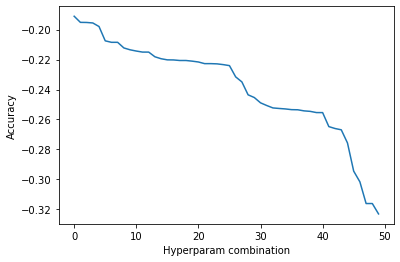

In [30]:
results['loss'].plot()
plt.ylabel('Accuracy')
plt.xlabel('Hyperparam combination')

In [31]:
pd.DataFrame(trials.results)['loss'].min()

-0.3230646152107367